# import library

In [13]:
import pandas as pd
import glob
import os 
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score
import scipy.stats as stats
from sklearn import metrics
from sklearn.metrics import classification_report

In [14]:
def one_hot_encoding(data,columns):
    for column in columns:
        print(column)
        dummies=pd.get_dummies(data[[column]])
        data =pd.concat([data,dummies],axis=1)
    return data
      

In [15]:
def checkUniqueAndCount(data):
    for column in data.columns:
        print(column)
        print(data[column].value_counts())
        print("next")
        print("")
    

# Data Understanding

## data integration-Collect initial data:

In [16]:

path = r"dataset/"

# Get all CSV files in the directory
xlsx_files = glob.glob(os.path.join(path, "*.xlsx"))

data = {}

for f in xlsx_files:
    # read the csv file
    df = pd.read_excel(f)
      
    # print the location and filename
    print('Location:', f)
    print('File Name:', os.path.basename(f))
      
    # print the content
    print('Content:')
    name = os.path.basename(f).replace('.xlsx','')
    data[name] = df


Location: dataset\CustomerChurn.xlsx
File Name: CustomerChurn.xlsx
Content:
Location: dataset\Telco_customer_churn.xlsx
File Name: Telco_customer_churn.xlsx
Content:
Location: dataset\Telco_customer_churn_demographics.xlsx
File Name: Telco_customer_churn_demographics.xlsx
Content:
Location: dataset\Telco_customer_churn_location.xlsx
File Name: Telco_customer_churn_location.xlsx
Content:
Location: dataset\Telco_customer_churn_population.xlsx
File Name: Telco_customer_churn_population.xlsx
Content:
Location: dataset\Telco_customer_churn_services.xlsx
File Name: Telco_customer_churn_services.xlsx
Content:
Location: dataset\Telco_customer_churn_status.xlsx
File Name: Telco_customer_churn_status.xlsx
Content:


In [17]:
data

{'CustomerChurn':       LoyaltyID Customer ID Senior Citizen Partner Dependents  Tenure  \
 0        318537  7590-VHVEG             No     Yes         No       1   
 1        152148  5575-GNVDE             No      No         No      34   
 2        326527  3668-QPYBK             No      No         No       2   
 3        845894  7795-CFOCW             No      No         No      45   
 4        503388  9237-HQITU             No      No         No       2   
 ...         ...         ...            ...     ...        ...     ...   
 7038     810338  6840-RESVB             No     Yes        Yes      24   
 7039     230811  2234-XADUH             No     Yes        Yes      72   
 7040     155157  4801-JZAZL             No     Yes        Yes      11   
 7041     731782  8361-LTMKD            Yes     Yes         No       4   
 7042     353947  3186-AJIEK             No      No         No      66   
 
      Phone Service    Multiple Lines Internet Service Online Security  \
 0               No

### 2.2 load demographic data

In [18]:
customer_churn_data =data["Telco_customer_churn_demographics"]

In [19]:
customer_churn_data

,Customer ID,Count,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents
0,8779-QRDMV,1,Male,78,No,Yes,No,No,0
1,7495-OOKFY,1,Female,74,No,Yes,Yes,Yes,1
2,1658-BYGOY,1,Male,71,No,Yes,No,Yes,3
3,4598-XLKNJ,1,Female,78,No,Yes,Yes,Yes,1
4,4846-WHAFZ,1,Female,80,No,Yes,Yes,Yes,1
...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,Female,30,No,No,No,No,0
7039,6840-RESVB,1,Male,38,No,No,Yes,Yes,2
7040,2234-XADUH,1,Female,30,No,No,Yes,Yes,2
7041,4801-JZAZL,1,Female,32,No,No,Yes,Yes,2


### 2.3 integration demographic dataset with location dataset based on ID

In [20]:
customer_churn_data=customer_churn_data.merge(data["Telco_customer_churn_location"],how="inner")

In [21]:
customer_churn_data.shape

(7043, 17)

In [22]:
customer_churn_data["Number of Dependents"].max()

9

# Data preparation

### drop unnessary columns

### the reason to drop Lat Long is because derived from Latitude and Longitude 
### the reason to drop Count, Country and state variables is because variability of data is because column variance is equal to zero

In [23]:
customer_churn_data.drop(columns=["Location ID","Lat Long"],inplace=True)

In [24]:
print(customer_churn_data.State.unique())
print(customer_churn_data.Country.unique())
print(customer_churn_data.Count.unique())

['California']
['United States']
[1]


In [25]:
customer_churn_data.drop(columns=["State","Count","Country"],inplace=True)


### remove dependents variable due to Number of Dependents variable highly correlated and can replace it
### VIF between 5 and 10 will mean that variables are highly correlated

In [26]:
 customer_churn_data[["Dependents","Number of Dependents"]].copy().head(10)

,Dependents,Number of Dependents
0,No,0
1,Yes,1
2,Yes,3
3,Yes,1
4,Yes,1
5,Yes,1
6,Yes,2
7,No,0
8,Yes,2
9,Yes,2


In [27]:
vif_data = customer_churn_data[["Dependents","Number of Dependents"]].copy()
vif= pd.DataFrame()

In [28]:
vif_data.Dependents=vif_data.Dependents.map({"No":0,"Yes":1})

In [29]:
vif["features"]= vif_data.columns

vif["VIF socre"]=[variance_inflation_factor(vif_data.values,x) for x in range(vif.shape[0])]

In [30]:
vif

,features,VIF socre
0,Dependents,5.861464
1,Number of Dependents,5.861464


# handle city

In [31]:
customer_churn_data.City.value_counts().median()

4.0

In [32]:
len(customer_churn_data.City.value_counts()[customer_churn_data.City.value_counts()<=4])

820

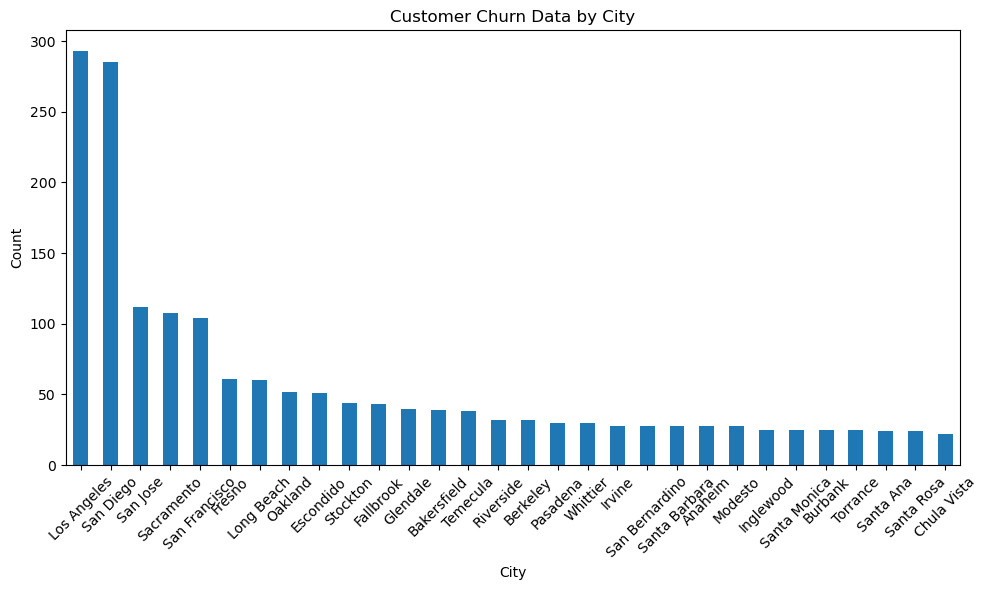

In [33]:
city_counts = customer_churn_data['City'].value_counts()[:30]

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
city_counts.plot(kind='bar')
plt.title('Customer Churn Data by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Grouping by Frequency
##  reduce the cardinality of high-cardinality categorical featuregroup them by frequency, or the number of times they appear in the data.

In [34]:
city_name=customer_churn_data.City.value_counts().to_dict()

In [35]:
customer_churn_data["city_transform"] = customer_churn_data.City.apply(lambda x: 1 if city_name[x] > 4 else 0)

## drop city and Dependents 

In [36]:
customer_churn_data.drop(columns=["Dependents","City"],inplace=True)

### perform one hot encoding for age

In [37]:
age=pd.get_dummies(customer_churn_data[["Under 30"]])

### create new column for age under 30_no and under 30_yes

In [38]:
customer_churn_data=pd.concat([customer_churn_data,age],axis=1)

In [39]:
customer_churn_data

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_No,Under 30_Yes
0,8779-QRDMV,Male,78,No,Yes,No,0,90022,34.023810,-118.156582,1,1,0
1,7495-OOKFY,Female,74,No,Yes,Yes,1,90063,34.044271,-118.185237,1,1,0
2,1658-BYGOY,Male,71,No,Yes,No,3,90065,34.108833,-118.229715,1,1,0
3,4598-XLKNJ,Female,78,No,Yes,Yes,1,90303,33.936291,-118.332639,1,1,0
4,4846-WHAFZ,Female,80,No,Yes,Yes,1,90602,33.972119,-118.020188,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,Female,30,No,No,No,0,92285,34.341737,-116.539416,0,1,0
7039,6840-RESVB,Male,38,No,No,Yes,2,92301,34.667815,-117.536183,1,1,0
7040,2234-XADUH,Female,30,No,No,Yes,2,92304,34.559882,-115.637164,1,1,0
7041,4801-JZAZL,Female,32,No,No,Yes,2,92305,34.167800,-116.864330,0,1,0


### remove multi-collinear after performing one hot encoding

In [40]:
customer_churn_data.drop(columns=["Age","Under 30","Under 30_No"],inplace=True)

In [41]:
customer_churn_data

,Customer ID,Gender,Senior Citizen,Married,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes
0,8779-QRDMV,Male,Yes,No,0,90022,34.023810,-118.156582,1,0
1,7495-OOKFY,Female,Yes,Yes,1,90063,34.044271,-118.185237,1,0
2,1658-BYGOY,Male,Yes,No,3,90065,34.108833,-118.229715,1,0
3,4598-XLKNJ,Female,Yes,Yes,1,90303,33.936291,-118.332639,1,0
4,4846-WHAFZ,Female,Yes,Yes,1,90602,33.972119,-118.020188,1,0
...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,Female,No,No,0,92285,34.341737,-116.539416,0,0
7039,6840-RESVB,Male,No,Yes,2,92301,34.667815,-117.536183,1,0
7040,2234-XADUH,Female,No,Yes,2,92304,34.559882,-115.637164,1,0
7041,4801-JZAZL,Female,No,Yes,2,92305,34.167800,-116.864330,0,0


### perform one hot encoding for gender, senior citizen and married

In [42]:
customer_churn_data= one_hot_encoding(customer_churn_data,['Gender', 'Senior Citizen', 'Married'])

Gender
Senior Citizen
Married


### remove multi-collinear after performing one hot encoding

In [43]:
customer_churn_data.drop(columns=["Gender_Female","Senior Citizen_No","Married_No"],inplace=True)

In [44]:
customer_churn_data.drop(columns=["Gender","Senior Citizen","Married"],inplace=True)

# data understanding for combined demographics and location dataset

## check duplicates 

In [45]:
#no duplicates
customer_churn_data.duplicated().any()

False

## check NA 

In [46]:
#no na
customer_churn_data.isna().any()

Customer ID             False
Number of Dependents    False
Zip Code                False
Latitude                False
Longitude               False
city_transform          False
Under 30_Yes            False
Gender_Male             False
Senior Citizen_Yes      False
Married_Yes             False
dtype: bool

# Data understanding

## integration population based on Zip code

In [47]:
customer_churn_data=customer_churn_data.merge(data["Telco_customer_churn_population"],how="inner",on="Zip Code")

In [48]:
customer_churn_data

,Customer ID,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,ID,Population
0,8779-QRDMV,0,90022,34.023810,-118.156582,1,0,1,1,0,21,68701
1,4737-AQCPU,0,90022,34.023810,-118.156582,1,0,1,0,1,21,68701
2,5043-TRZWM,0,90022,34.023810,-118.156582,1,0,0,0,0,21,68701
3,8165-CBKXO,3,90022,34.023810,-118.156582,1,0,1,0,1,21,68701
4,9979-RGMZT,0,90022,34.023810,-118.156582,1,1,0,0,0,21,68701
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9108-EJFJP,0,91934,32.649787,-116.223700,0,1,0,0,1,303,699
7039,0795-GMVQO,0,92105,32.741859,-117.090353,1,0,1,0,1,357,73006
7040,9547-ITEFG,3,92105,32.741859,-117.090353,1,0,1,0,1,357,73006
7041,4993-JCRGJ,0,92250,32.811001,-115.152865,0,0,1,0,0,404,8062


## check NA and duplicate

In [49]:
print(customer_churn_data.isna().any())
print("")
print(customer_churn_data.duplicated().any())

Customer ID             False
Number of Dependents    False
Zip Code                False
Latitude                False
Longitude               False
city_transform          False
Under 30_Yes            False
Gender_Male             False
Senior Citizen_Yes      False
Married_Yes             False
ID                      False
Population              False
dtype: bool

False


# Data preparation

## drop unnessary column

In [50]:
customer_churn_data.drop(columns="ID",inplace=True)

In [51]:
customer_churn_data

,Customer ID,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population
0,8779-QRDMV,0,90022,34.023810,-118.156582,1,0,1,1,0,68701
1,4737-AQCPU,0,90022,34.023810,-118.156582,1,0,1,0,1,68701
2,5043-TRZWM,0,90022,34.023810,-118.156582,1,0,0,0,0,68701
3,8165-CBKXO,3,90022,34.023810,-118.156582,1,0,1,0,1,68701
4,9979-RGMZT,0,90022,34.023810,-118.156582,1,1,0,0,0,68701
...,...,...,...,...,...,...,...,...,...,...,...
7038,9108-EJFJP,0,91934,32.649787,-116.223700,0,1,0,0,1,699
7039,0795-GMVQO,0,92105,32.741859,-117.090353,1,0,1,0,1,73006
7040,9547-ITEFG,3,92105,32.741859,-117.090353,1,0,1,0,1,73006
7041,4993-JCRGJ,0,92250,32.811001,-115.152865,0,0,1,0,0,8062


# Data understanding

## integration services dataset

In [52]:
customer_churn_data=customer_churn_data.merge(data["Telco_customer_churn_services"],how="inner")

In [53]:
customer_churn_data.Quarter.value_counts()

Q3    7043
Name: Quarter, dtype: int64

## check NA and duplicate

In [54]:
print(customer_churn_data.isna().any())
print("")
print(customer_churn_data.duplicated().any())

Customer ID                          False
Number of Dependents                 False
Zip Code                             False
Latitude                             False
Longitude                            False
city_transform                       False
Under 30_Yes                         False
Gender_Male                          False
Senior Citizen_Yes                   False
Married_Yes                          False
Population                           False
Service ID                           False
Count                                False
Quarter                              False
Referred a Friend                    False
Number of Referrals                  False
Tenure in Months                     False
Offer                                False
Phone Service                        False
Avg Monthly Long Distance Charges    False
Multiple Lines                       False
Internet Service                     False
Internet Type                        False
Avg Monthly

# drop unnessary columns

In [55]:
customer_churn_data.columns

Index(['Customer ID', 'Number of Dependents', 'Zip Code', 'Latitude',
       'Longitude', 'city_transform', 'Under 30_Yes', 'Gender_Male',
       'Senior Citizen_Yes', 'Married_Yes', 'Population', 'Service ID',
       'Count', 'Quarter', 'Referred a Friend', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue'],
      dtype='object')

In [56]:
# the reason to drop Total Charges,Total Extra Data Charges and Total Long Distance Charges is because Total Revenue value derived from these columns

## VIF for charges
## VIF-measures the strength of the correlation between the independent variables

In [57]:
vif_data = customer_churn_data[['Total Charges',"Total Extra Data Charges","Total Long Distance Charges","Total Revenue"]].copy()
vif= pd.DataFrame()

In [58]:
vif["features"]= vif_data.columns

vif["VIF socre"]=[variance_inflation_factor(vif_data.values,x) for x in range(vif.shape[0])]

In [59]:
vif

,features,VIF socre
0,Total Charges,162516.089142
1,Total Extra Data Charges,11.552219
2,Total Long Distance Charges,20092.844657
3,Total Revenue,274045.716720


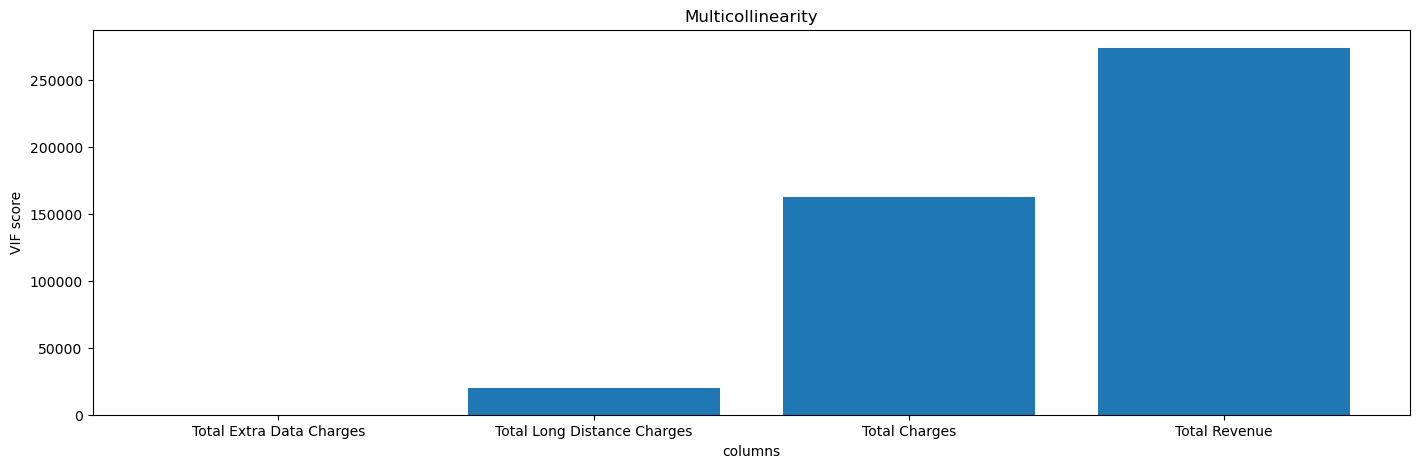

In [60]:
plt.figure(figsize=(17,5))
plt.bar(x=vif.sort_values(by="VIF socre")["features"], height=vif.sort_values(by="VIF socre")["VIF socre"])
plt.title("Multicollinearity")
plt.xlabel("columns")
plt.ylabel("VIF score")
plt.show()

## after removing Total revenue
##  the reason to drop revenue is because Total Revenue value derived from these Total 
## Charges,Total Extra Data Charges and Total Long Distance variables

In [61]:
vif_data = customer_churn_data[['Total Charges',"Total Extra Data Charges","Total Long Distance Charges"]].copy()
vif= pd.DataFrame()

In [62]:
vif["features"]= vif_data.columns

vif["VIF socre"]=[variance_inflation_factor(vif_data.values,x) for x in range(vif.shape[0])]

In [63]:
vif

,features,VIF socre
0,Total Charges,2.759026
1,Total Extra Data Charges,1.078581
2,Total Long Distance Charges,2.684794


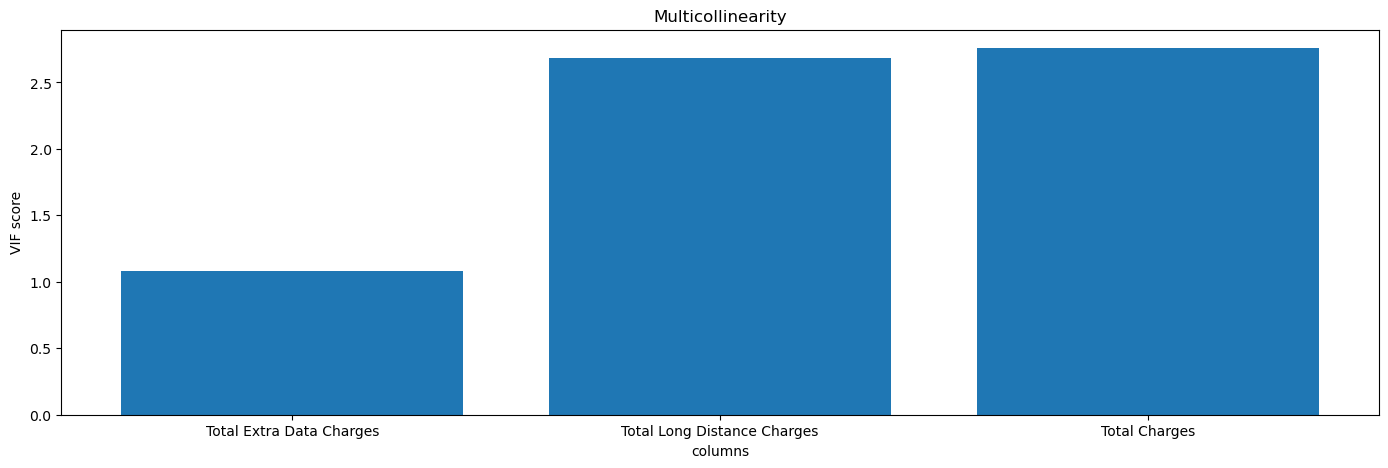

In [64]:
plt.figure(figsize=(17,5))
plt.bar(x=vif.sort_values(by="VIF socre")["features"], height=vif.sort_values(by="VIF socre")["VIF socre"])
plt.title("Multicollinearity")
plt.xlabel("columns")
plt.ylabel("VIF score")
plt.show()

In [65]:
# customer_churn_data.drop(columns=["Total Revenue", "Service ID", "Count","Quarter" ],inplace=True)

In [66]:
customer_churn_data.drop(columns=["Service ID", "Count","Quarter",'Total Revenue'],inplace=True)

## Offer: Identifies the last marketing offer that the customer accepted, if applicable. Values include None, Offer A, Offer B, Offer C, Offer D, and Offer E.
## Since we don't know information and details about each offer, so decide to convert to either accept offer or not accept offer

In [67]:
customer_churn_data['Offer']= customer_churn_data["Offer"].apply(lambda x: 1 if x!="None" else 0)

## one hot encoding for services

In [68]:
customer_churn_data=one_hot_encoding(customer_churn_data,["Referred a Friend","Phone Service",
                                      "Multiple Lines","Internet Service","Internet Type","Online Security","Online Backup",
                                      "Device Protection Plan","Premium Tech Support","Streaming TV","Streaming Movies",
                                      "Streaming Music","Unlimited Data","Paperless Billing","Payment Method"])

Referred a Friend
Phone Service
Multiple Lines
Internet Service
Internet Type
Online Security
Online Backup
Device Protection Plan
Premium Tech Support
Streaming TV
Streaming Movies
Streaming Music
Unlimited Data
Paperless Billing
Payment Method


In [69]:
customer_churn_data

,Customer ID,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_No,Referred a Friend_Yes,Phone Service_No,Phone Service_Yes,Multiple Lines_No,Multiple Lines_Yes,Internet Service_No,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Internet Type_None,Online Security_No,Online Security_Yes,Online Backup_No,Online Backup_Yes,Device Protection Plan_No,Device Protection Plan_Yes,Premium Tech Support_No,Premium Tech Support_Yes,Streaming TV_No,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_Yes,Streaming Music_No,Streaming Music_Yes,Unlimited Data_No,Unlimited Data_Yes,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check
0,8779-QRDMV,0,90022,34.023810,-118.156582,1,0,1,1,0,68701,No,0,1,0,No,0.00,No,Yes,DSL,8,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.0,20,0.00,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0,0
1,4737-AQCPU,0,90022,34.023810,-118.156582,1,0,1,0,1,68701,Yes,5,72,0,Yes,42.55,Yes,Yes,DSL,18,Yes,Yes,Yes,Yes,No,No,No,Yes,Two Year,No,Credit Card,72.10,5016.65,0.0,0,3063.60,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0
2,5043-TRZWM,0,90022,34.023810,-118.156582,1,0,0,0,0,68701,No,0,1,0,Yes,7.11,No,Yes,Fiber Optic,26,No,No,Yes,No,No,No,No,Yes,Month-to-Month,No,Bank Withdrawal,75.55,75.55,0.0,0,7.11,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0
3,8165-CBKXO,3,90022,34.023810,-118.156582,1,0,1,0,1,68701,Yes,4,66,0,No,0.00,No,Yes,Cable,25,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,56.75,3708.40,0.0,0,0.00,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0
4,9979-RGMZT,0,90022,34.023810,-118.156582,1,1,0,0,0,68701,No,0,7,1,Yes,36.49,No,Yes,Fiber Optic,42,No,Yes,No,No,Yes,Yes,Yes,Yes,One Year,Yes,Credit Card,94.05,633.45,0.0,0,255.43,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9108-EJFJP,0,91934,32.649787,-116.223700,0,1,0,0,1,699,Yes,6,1,1,Yes,16.06,No,Yes,DSL,59,Yes,Yes,No,No,No,No,Yes,Yes,Month-to-Month,Yes,Credit Card,53.55,53.55,0.0,0,16.06,0,1,0,1,1,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0
7039,0795-GMVQO,0,92105,32.741859,-117.090353,1,0,1,0,1,73006,Yes,1,67,0,Yes,23.13,Yes,Yes,Fiber Optic,24,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,One Year,No,Credit Card,109.90,7332.40,0.0,0,1549.71,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0
7040,9547-ITEFG,3,92105,32.741859,-117.090353,1,0,1,0,1,73006,Yes,8,9,1,Yes,23.42,Yes,Yes,Fiber Optic,30,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Credit Card,102.60,897.75,0.0,0,210.78,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0
7041,4993-JCRGJ,0,92250,32.811001,-115.152865,0,0,1,0,0,8062,No,0,26,0,Yes,37.69,Yes,Yes,Fiber Optic,30,No,No,Yes,Yes,No,No,No,Yes,Month-to-Month,Yes,Credit Card,84.30,2281.60,0.0,0,979.94,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0


#  remove multi-collinear after performing one hot encoding

In [70]:
customer_churn_data.drop(columns=["Referred a Friend_No","Phone Service_No",
                                  "Multiple Lines_No","Internet Service_No","Internet Type_None",
                                  "Online Security_No","Online Backup_No","Device Protection Plan_No","Premium Tech Support_No",
                                  "Streaming TV_No","Streaming Movies_No","Streaming Music_No","Unlimited Data_No","Paperless Billing_No","Payment Method_Credit Card"],inplace=True)

In [71]:
customer_churn_data['Contract']

0       Month-to-Month
1             Two Year
2       Month-to-Month
3             Two Year
4             One Year
             ...      
7038    Month-to-Month
7039          One Year
7040    Month-to-Month
7041    Month-to-Month
7042    Month-to-Month
Name: Contract, Length: 7043, dtype: object

## perform label encoding instead of one hot encoding because of this categorical feature present in the dataset are ordinal

In [72]:
encoder = LabelEncoder()
customer_churn_data["Contract_transform"]=pd.DataFrame({"Contract_transform":encoder.fit_transform(customer_churn_data["Contract"])})

In [73]:
print(encoder.classes_)

['Month-to-Month' 'One Year' 'Two Year']


In [74]:
customer_churn_data[["Contract_transform"]]

,Contract_transform
0,0
1,2
2,0
3,2
4,1
...,...
7038,0
7039,1
7040,0
7041,0


## remove original columns after performing one hot and label encoding

In [75]:
customer_churn_data.drop(columns=["Referred a Friend","Offer","Phone Service",
                                      "Multiple Lines","Internet Service","Internet Type","Online Security","Online Backup",
                                      "Device Protection Plan","Premium Tech Support","Streaming TV","Streaming Movies",
                                      "Streaming Music","Unlimited Data","Paperless Billing","Payment Method","Contract"],inplace=True)

# Data understanding
## integration status dataset

In [76]:
customer_churn_data=customer_churn_data.merge(data["Telco_customer_churn_status"],how="inner")

In [77]:
print(customer_churn_data.isna().any())
print("")
print(customer_churn_data.duplicated().any())

Customer ID                          False
Number of Dependents                 False
Zip Code                             False
Latitude                             False
Longitude                            False
city_transform                       False
Under 30_Yes                         False
Gender_Male                          False
Senior Citizen_Yes                   False
Married_Yes                          False
Population                           False
Number of Referrals                  False
Tenure in Months                     False
Avg Monthly Long Distance Charges    False
Avg Monthly GB Download              False
Monthly Charge                       False
Total Charges                        False
Total Refunds                        False
Total Extra Data Charges             False
Total Long Distance Charges          False
Referred a Friend_Yes                False
Phone Service_Yes                    False
Multiple Lines_Yes                   False
Internet Se

In [78]:
customer_churn_data

,Customer ID,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform,Status ID,Count,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,0,90022,34.023810,-118.156582,1,0,1,1,0,68701,0,1,0.00,8,39.65,39.65,0.0,20,0.00,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,SWSORB1252,1,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,4737-AQCPU,0,90022,34.023810,-118.156582,1,0,1,0,1,68701,5,72,42.55,18,72.10,5016.65,0.0,0,3063.60,1,1,1,1,0,1,0,1,1,1,1,0,0,0,1,0,0,0,2,DFFTSW9423,1,Q3,3,Stayed,No,0,42,4658,NaN,NaN
2,5043-TRZWM,0,90022,34.023810,-118.156582,1,0,0,0,0,68701,0,1,7.11,26,75.55,75.55,0.0,0,7.11,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,ZQUQGL3189,1,Q3,5,Joined,No,0,34,3503,NaN,NaN
3,8165-CBKXO,3,90022,34.023810,-118.156582,1,0,1,0,1,68701,4,66,0.00,25,56.75,3708.40,0.0,0,0.00,1,0,0,1,1,0,0,0,1,1,0,1,1,1,1,1,0,0,2,GJIIZD8512,1,Q3,3,Stayed,No,0,46,5748,NaN,NaN
4,9979-RGMZT,0,90022,34.023810,-118.156582,1,1,0,0,0,68701,0,7,36.49,42,94.05,633.45,0.0,0,255.43,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,1,CKVIIN3951,1,Q3,3,Stayed,No,0,38,5545,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9108-EJFJP,0,91934,32.649787,-116.223700,0,1,0,0,1,699,6,1,16.06,59,53.55,53.55,0.0,0,16.06,1,1,0,1,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,BABZIZ1275,1,Q3,4,Joined,No,0,62,4504,NaN,NaN
7039,0795-GMVQO,0,92105,32.741859,-117.090353,1,0,1,0,1,73006,1,67,23.13,24,109.90,7332.40,0.0,0,1549.71,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,0,0,1,JLWIWU8939,1,Q3,4,Stayed,No,0,26,5416,NaN,NaN
7040,9547-ITEFG,3,92105,32.741859,-117.090353,1,0,1,0,1,73006,8,9,23.42,30,102.60,897.75,0.0,0,210.78,1,1,1,1,0,0,1,0,1,1,0,1,1,1,1,1,0,0,0,OUDVAY1482,1,Q3,5,Stayed,No,0,32,4062,NaN,NaN
7041,4993-JCRGJ,0,92250,32.811001,-115.152865,0,0,1,0,0,8062,0,26,37.69,30,84.30,2281.60,0.0,0,979.94,0,1,1,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,OPGYTC4522,1,Q3,5,Stayed,No,0,66,5471,NaN,NaN


# data preparation
## drop all the unnessary variables and other target variables and only keep churn value target variable

In [79]:
customer_churn_data.drop(columns=["Status ID","Count","Quarter","Churn Label", 'Satisfaction Score',"Customer Status","Churn Category","Churn Reason","Churn Score","CLTV"],inplace=True)

In [80]:
customer_churn_data.columns

Index(['Customer ID', 'Number of Dependents', 'Zip Code', 'Latitude',
       'Longitude', 'city_transform', 'Under 30_Yes', 'Gender_Male',
       'Senior Citizen_Yes', 'Married_Yes', 'Population',
       'Number of Referrals', 'Tenure in Months',
       'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
       'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Referred a Friend_Yes', 'Phone Service_Yes', 'Multiple Lines_Yes',
       'Internet Service_Yes', 'Internet Type_Cable', 'Internet Type_DSL',
       'Internet Type_Fiber Optic', 'Online Security_Yes', 'Online Backup_Yes',
       'Device Protection Plan_Yes', 'Premium Tech Support_Yes',
       'Streaming TV_Yes', 'Streaming Movies_Yes', 'Streaming Music_Yes',
       'Unlimited Data_Yes', 'Paperless Billing_Yes',
       'Payment Method_Bank Withdrawal', 'Payment Method_Mailed Check',
       'Contract_transform', 'Churn Value'],
      dtype='obje

# final dataset

In [81]:
#customer_churn_data.drop(columns="Satisfaction Score",inplace=True)

In [82]:
customer_churn_data.drop(columns="Customer ID",inplace=True)


## Explore Data

In [83]:
customer_churn_data.columns


Index(['Number of Dependents', 'Zip Code', 'Latitude', 'Longitude',
       'city_transform', 'Under 30_Yes', 'Gender_Male', 'Senior Citizen_Yes',
       'Married_Yes', 'Population', 'Number of Referrals', 'Tenure in Months',
       'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
       'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Referred a Friend_Yes', 'Phone Service_Yes', 'Multiple Lines_Yes',
       'Internet Service_Yes', 'Internet Type_Cable', 'Internet Type_DSL',
       'Internet Type_Fiber Optic', 'Online Security_Yes', 'Online Backup_Yes',
       'Device Protection Plan_Yes', 'Premium Tech Support_Yes',
       'Streaming TV_Yes', 'Streaming Movies_Yes', 'Streaming Music_Yes',
       'Unlimited Data_Yes', 'Paperless Billing_Yes',
       'Payment Method_Bank Withdrawal', 'Payment Method_Mailed Check',
       'Contract_transform', 'Churn Value'],
      dtype='object')

In [84]:
checkUniqueAndCount(customer_churn_data)

Number of Dependents
0    5416
1     553
2     531
3     517
5      10
4       9
6       3
7       2
8       1
9       1
Name: Number of Dependents, dtype: int64
next

Zip Code
92028    43
92027    38
92122    36
92117    34
92126    32
         ..
95431     2
91934     2
92105     2
92250     2
93711     1
Name: Zip Code, Length: 1625, dtype: int64
next

Latitude
33.362575    43
33.141265    38
32.857230    36
32.825086    34
32.886925    32
             ..
38.911577     2
35.363339     2
38.348884     2
32.811001     2
36.833002     1
Name: Latitude, Length: 1626, dtype: int64
next

Longitude
-117.299644    43
-116.967221    38
-117.209774    36
-117.199424    34
-117.152162    32
               ..
-122.516990     2
-116.223700     2
-117.090353     2
-115.152865     2
-119.829470     1
Name: Longitude, Length: 1625, dtype: int64
next

city_transform
1    3807
0    3236
Name: city_transform, dtype: int64
next

Under 30_Yes
0    5642
1    1401
Name: Under 30_Yes, dtype: int64
next

Ge

# total null value

In [85]:
customer_churn_data.isna().any()

Number of Dependents                 False
Zip Code                             False
Latitude                             False
Longitude                            False
city_transform                       False
Under 30_Yes                         False
Gender_Male                          False
Senior Citizen_Yes                   False
Married_Yes                          False
Population                           False
Number of Referrals                  False
Tenure in Months                     False
Avg Monthly Long Distance Charges    False
Avg Monthly GB Download              False
Monthly Charge                       False
Total Charges                        False
Total Refunds                        False
Total Extra Data Charges             False
Total Long Distance Charges          False
Referred a Friend_Yes                False
Phone Service_Yes                    False
Multiple Lines_Yes                   False
Internet Service_Yes                 False
Internet Ty

In [86]:
customer_churn_data.isnull().sum()

Number of Dependents                 0
Zip Code                             0
Latitude                             0
Longitude                            0
city_transform                       0
Under 30_Yes                         0
Gender_Male                          0
Senior Citizen_Yes                   0
Married_Yes                          0
Population                           0
Number of Referrals                  0
Tenure in Months                     0
Avg Monthly Long Distance Charges    0
Avg Monthly GB Download              0
Monthly Charge                       0
Total Charges                        0
Total Refunds                        0
Total Extra Data Charges             0
Total Long Distance Charges          0
Referred a Friend_Yes                0
Phone Service_Yes                    0
Multiple Lines_Yes                   0
Internet Service_Yes                 0
Internet Type_Cable                  0
Internet Type_DSL                    0
Internet Type_Fiber Optic

# dupliates value

In [87]:
customer_churn_data.duplicated().any()

False

# total unique value

In [88]:
customer_churn_data.nunique().sort_values(ascending=False)

Total Charges                        6540
Total Long Distance Charges          6110
Avg Monthly Long Distance Charges    3584
Latitude                             1626
Longitude                            1625
Zip Code                             1625
Monthly Charge                       1585
Population                           1569
Total Refunds                         500
Tenure in Months                       72
Avg Monthly GB Download                50
Total Extra Data Charges               16
Number of Referrals                    12
Number of Dependents                   10
Contract_transform                      3
Online Security_Yes                     2
Unlimited Data_Yes                      2
Paperless Billing_Yes                   2
Payment Method_Bank Withdrawal          2
Payment Method_Mailed Check             2
Streaming Music_Yes                     2
Streaming Movies_Yes                    2
Streaming TV_Yes                        2
Premium Tech Support_Yes          

In [89]:
customer_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Number of Dependents               7043 non-null   int64  
 1   Zip Code                           7043 non-null   int64  
 2   Latitude                           7043 non-null   float64
 3   Longitude                          7043 non-null   float64
 4   city_transform                     7043 non-null   int64  
 5   Under 30_Yes                       7043 non-null   uint8  
 6   Gender_Male                        7043 non-null   uint8  
 7   Senior Citizen_Yes                 7043 non-null   uint8  
 8   Married_Yes                        7043 non-null   uint8  
 9   Population                         7043 non-null   int64  
 10  Number of Referrals                7043 non-null   int64  
 11  Tenure in Months                   7043 non-null   int64

In [90]:
customer_churn_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Number of Dependents,7043.0,0.468692,0.962802,0.000000,0.000000,0.000000,0.000000,9.000000
Zip Code,7043.0,93486.071134,1856.768045,90001.000000,92101.000000,93518.000000,95329.000000,96150.000000
Latitude,7043.0,36.197455,2.468929,32.555828,33.990646,36.205465,38.161321,41.962127
Longitude,7043.0,-119.756684,2.154425,-124.301372,-121.788090,-119.595293,-117.969795,-114.192901
city_transform,7043.0,0.540537,0.498389,0.000000,0.000000,1.000000,1.000000,1.000000
Under 30_Yes,7043.0,0.198921,0.399217,0.000000,0.000000,0.000000,0.000000,1.000000
Gender_Male,7043.0,0.504756,0.500013,0.000000,0.000000,1.000000,1.000000,1.000000
Senior Citizen_Yes,7043.0,0.162147,0.368612,0.000000,0.000000,0.000000,0.000000,1.000000
Married_Yes,7043.0,0.483033,0.499748,0.000000,0.000000,0.000000,1.000000,1.000000
Population,7043.0,22139.814568,21152.174407,11.000000,2344.000000,17554.000000,36125.000000,105285.000000


# visualization

##  check distribution for dependent variable

In [91]:
customer_churn_data["Churn Value"].value_counts()

0    5174
1    1869
Name: Churn Value, dtype: int64

In [92]:
noChurn_quantity= customer_churn_data["Churn Value"].value_counts()[0]
Churn_quantity= customer_churn_data["Churn Value"].value_counts()[1]

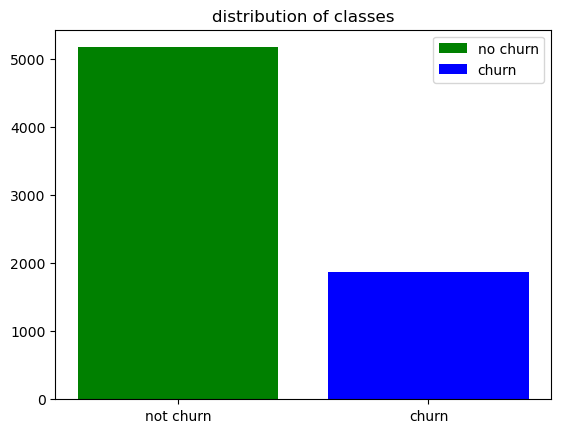

In [93]:
colors = ['g', 'b']
x=np.array(["not churn","churn"])
y=np.array([noChurn_quantity,Churn_quantity])
plt.bar(x[0],y[0],color=colors[0])
plt.bar(x[1],y[1],color=colors[1])
plt.title("distribution of classes")
legend_labels = ["no churn", "churn"]
plt.legend(legend_labels)
plt.show()

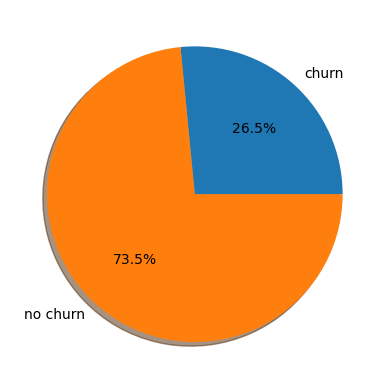

In [94]:
percentage_of_churn = len(customer_churn_data[customer_churn_data["Churn Value"]==1])/len(customer_churn_data)
plt.pie([percentage_of_churn,1-percentage_of_churn],labels=["churn","no churn"],autopct='%1.1f%%',shadow = True)
plt.show()

## Given that dataset has an imbalance in both independent variables and dependent variables
## Normalized Stacked Bar Plot: Instead of using raw counts,  comparing proportions rather than raw counts, which can provide a more balanced view
## This helps in comparing the distribution of different categories in a fair manner, especially when dealing with imbalanced data.

## Premium Tech Support

## differences between using raw count and proportions

In [95]:
customer_churn_data['Premium Tech Support_Yes'].value_counts()

0    4999
1    2044
Name: Premium Tech Support_Yes, dtype: int64

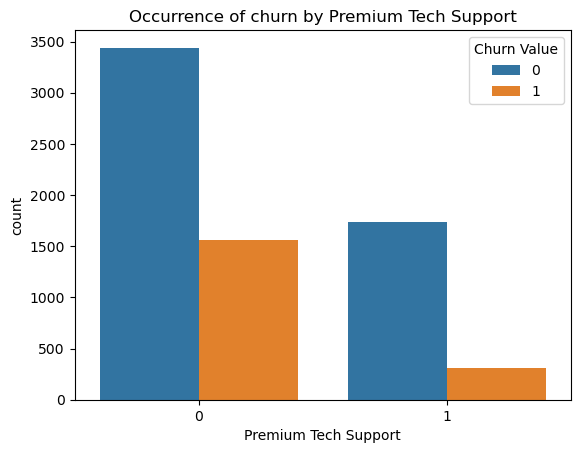

In [96]:
sns.countplot(x='Premium Tech Support_Yes', hue='Churn Value', data=customer_churn_data)
plt.title('Occurrence of churn by Premium Tech Support')
plt.xlabel("Premium Tech Support")
plt.ylabel("count")
plt.show()

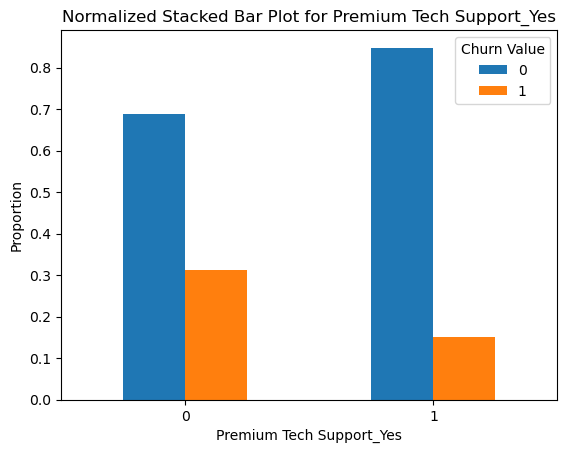

In [97]:
normalized_data = customer_churn_data.groupby(['Premium Tech Support_Yes', 'Churn Value']).size().unstack().apply(lambda row: row / row.sum(), axis=1)

# Create a normalized stacked bar plot
normalized_data.plot(kind='bar')
plt.title('Normalized Stacked Bar Plot for Premium Tech Support_Yes')
plt.xlabel('Premium Tech Support_Yes')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Churn Value')
plt.show()

In [98]:
customer_churn_data.columns

Index(['Number of Dependents', 'Zip Code', 'Latitude', 'Longitude',
       'city_transform', 'Under 30_Yes', 'Gender_Male', 'Senior Citizen_Yes',
       'Married_Yes', 'Population', 'Number of Referrals', 'Tenure in Months',
       'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
       'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Referred a Friend_Yes', 'Phone Service_Yes', 'Multiple Lines_Yes',
       'Internet Service_Yes', 'Internet Type_Cable', 'Internet Type_DSL',
       'Internet Type_Fiber Optic', 'Online Security_Yes', 'Online Backup_Yes',
       'Device Protection Plan_Yes', 'Premium Tech Support_Yes',
       'Streaming TV_Yes', 'Streaming Movies_Yes', 'Streaming Music_Yes',
       'Unlimited Data_Yes', 'Paperless Billing_Yes',
       'Payment Method_Bank Withdrawal', 'Payment Method_Mailed Check',
       'Contract_transform', 'Churn Value'],
      dtype='object')

## Senior citizen

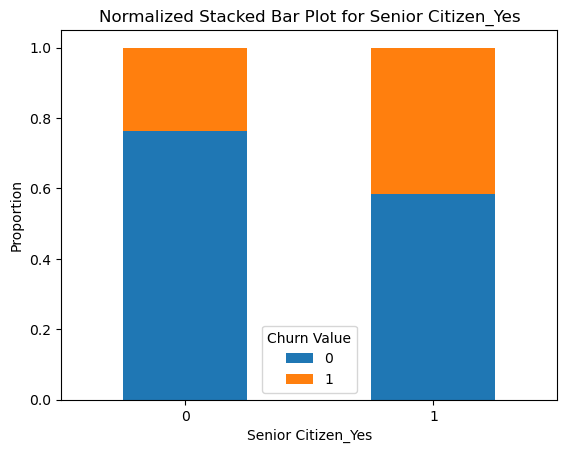

In [99]:
normalized_data = customer_churn_data.groupby(['Senior Citizen_Yes', 'Churn Value']).size().unstack().apply(lambda row: row / row.sum(), axis=1)

normalized_data.plot(kind='bar',stacked=True)
plt.title('Normalized Stacked Bar Plot for Senior Citizen_Yes')
plt.xlabel('Senior Citizen_Yes')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Churn Value')
plt.show()

## Internet Type_DSL and fiber

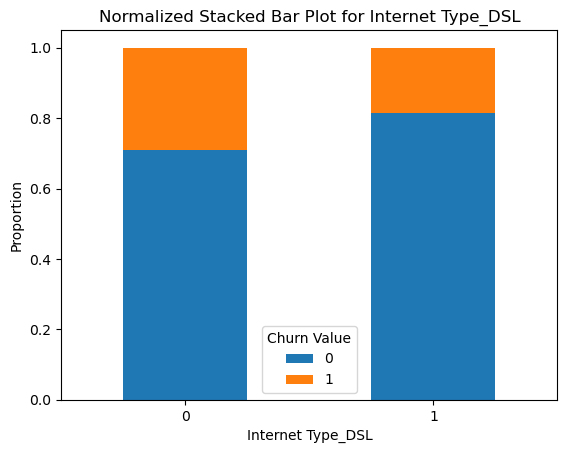

In [100]:
normalized_data = customer_churn_data.groupby(['Internet Type_DSL', 'Churn Value']).size().unstack().apply(lambda row: row / row.sum(), axis=1)

normalized_data.plot(kind='bar',stacked=True)
plt.title('Normalized Stacked Bar Plot for Internet Type_DSL')
plt.xlabel('Internet Type_DSL')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Churn Value')
plt.show()

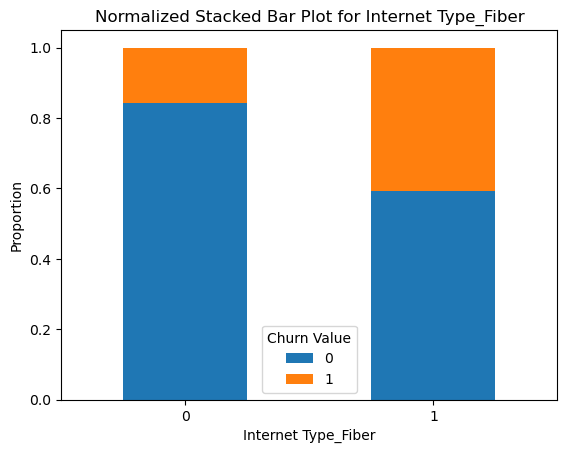

In [101]:
normalized_data = customer_churn_data.groupby(['Internet Type_Fiber Optic', 'Churn Value']).size().unstack().apply(lambda row: row / row.sum(), axis=1)

normalized_data.plot(kind='bar',stacked=True)
plt.title('Normalized Stacked Bar Plot for Internet Type_Fiber')
plt.xlabel('Internet Type_Fiber')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Churn Value')
plt.show()

## streaming TV

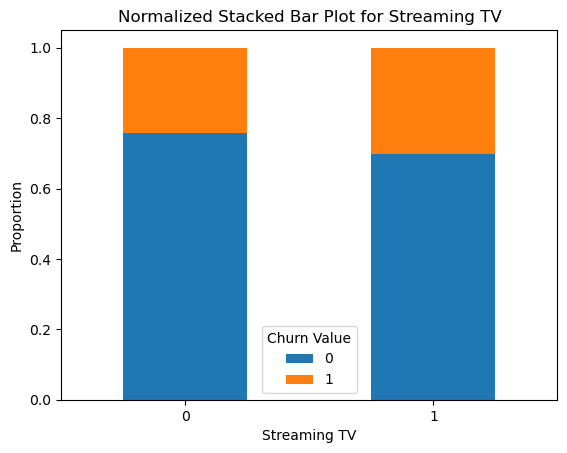

In [102]:
normalized_data = customer_churn_data.groupby([ 'Streaming TV_Yes', 'Churn Value']).size().unstack().apply(lambda row: row / row.sum(), axis=1)

normalized_data.plot(kind='bar',stacked=True)
plt.title('Normalized Stacked Bar Plot for Streaming TV')
plt.xlabel('Streaming TV')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Churn Value')
plt.show()

## contract 

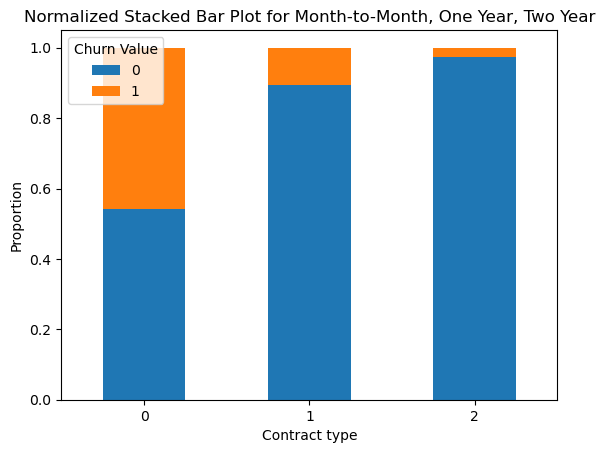

In [103]:
normalized_data = customer_churn_data.groupby([ 'Contract_transform', 'Churn Value']).size().unstack().apply(lambda row: row / row.sum(), axis=1)

normalized_data.plot(kind='bar',stacked=True)
plt.title('Normalized Stacked Bar Plot for Month-to-Month, One Year, Two Year')
plt.xlabel('Contract type')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Churn Value')
plt.show()

## Online Security_Yes

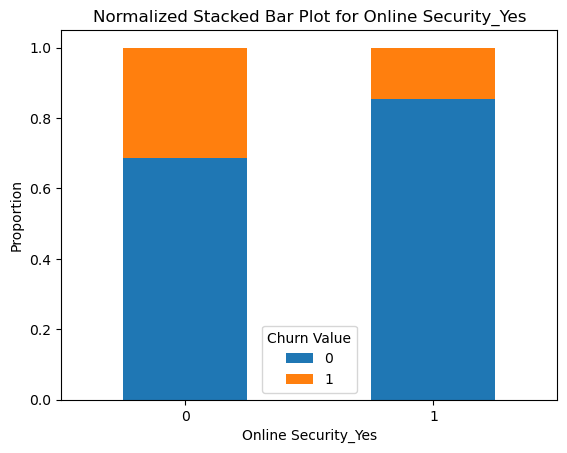

In [104]:
normalized_data = customer_churn_data.groupby([ 'Online Security_Yes', 'Churn Value']).size().unstack().apply(lambda row: row / row.sum(), axis=1)

normalized_data.plot(kind='bar',stacked=True)
plt.title('Normalized Stacked Bar Plot for Online Security_Yes')
plt.xlabel('Online Security_Yes')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Churn Value')
plt.show()

# number of referrels

In [105]:
normalized_data = customer_churn_data.groupby([ 'Number of Referrals', 'Churn Value']).size().unstack().apply(lambda row: row / row.sum(), axis=1)

In [106]:
normalized_data=normalized_data[normalized_data.index<10]
normalized_data

Churn Value,0,1
Number of Referrals,,
0,0.674169,0.325831
1,0.533149,0.466851
2,0.889831,0.110169
3,0.874510,0.125490
4,0.923729,0.076271
5,0.920455,0.079545
6,0.963801,0.036199
7,0.975806,0.024194
8,0.990610,0.009390


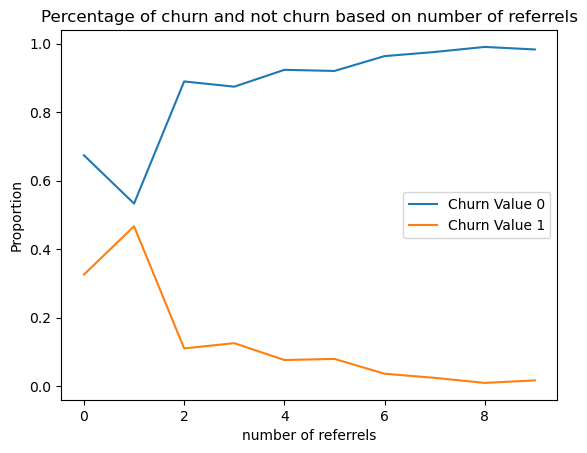

In [107]:
plt.plot(normalized_data[0], label='Churn Value 0')
plt.plot(normalized_data[1], label='Churn Value 1')
plt.xlabel("number of referrels")
plt.ylabel("Proportion")
plt.title("Percentage of churn and not churn based on number of referrels")
plt.legend()
plt.show()

## number of dependents

In [108]:
normalized_data = customer_churn_data.groupby([ 'Number of Dependents', 'Churn Value']).size().unstack().apply(lambda row: row / row.sum(), axis=1)

In [109]:
normalized_data=normalized_data[normalized_data.index<8]
normalized_data

Churn Value,0,1
Number of Dependents,,
0,0.674483,0.325517
1,0.931284,0.068716
2,0.937853,0.062147
3,0.941973,0.058027
4,0.888889,0.111111
5,0.800000,0.200000
6,0.666667,0.333333
7,0.500000,0.500000


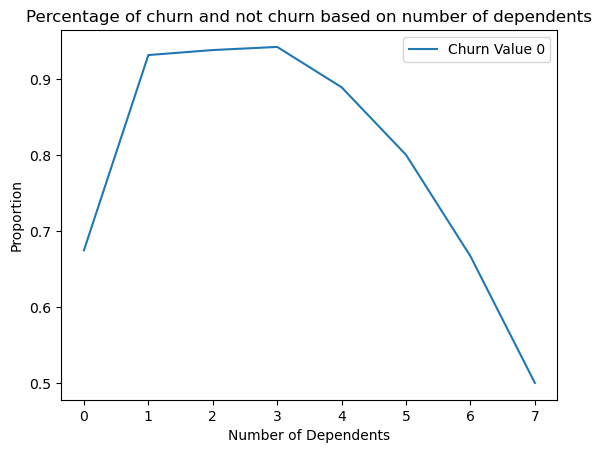

In [110]:
plt.plot(normalized_data[0], label='Churn Value 0')
plt.xlabel("Number of Dependents")
plt.ylabel("Proportion")
plt.title("Percentage of churn and not churn based on number of dependents")
plt.legend()
plt.show()

## Total Extra Data Charges

In [111]:
charges=  customer_churn_data[customer_churn_data["Total Extra Data Charges"]>0]

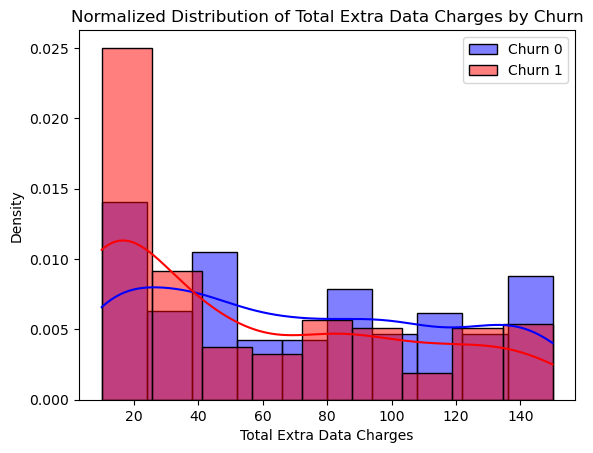

In [112]:
# Separate data for Churn = 0 and Churn = 1
data_churn_0 = charges[charges['Churn Value'] == 0]['Total Extra Data Charges']
data_churn_1 = charges[charges['Churn Value'] == 1]['Total Extra Data Charges']

# Normalize the histograms
sns.histplot(data_churn_0, kde=True, label='Churn 0', color='blue', stat="density")
sns.histplot(data_churn_1, kde=True, label='Churn 1', color='red', stat="density")

plt.xlabel('Total Extra Data Charges')
plt.ylabel('Density')
plt.title('Normalized Distribution of Total Extra Data Charges by Churn')
plt.legend()
plt.show()

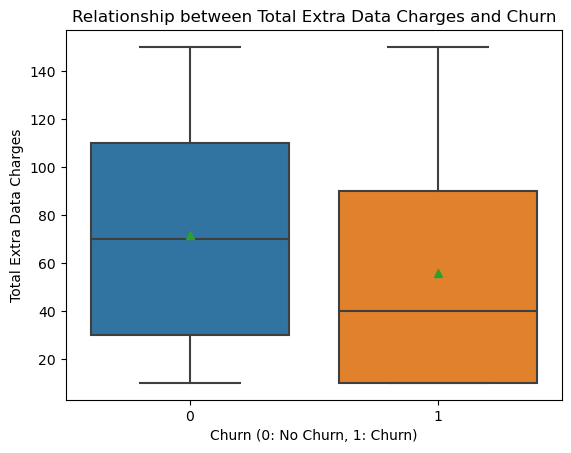

In [113]:
sns.boxplot(x='Churn Value', y='Total Extra Data Charges', data=charges, showmeans=True)
plt.xlabel('Churn (0: No Churn, 1: Churn)')
plt.ylabel('Total Extra Data Charges')
plt.title('Relationship between Total Extra Data Charges and Churn')
plt.show()

## montly charge

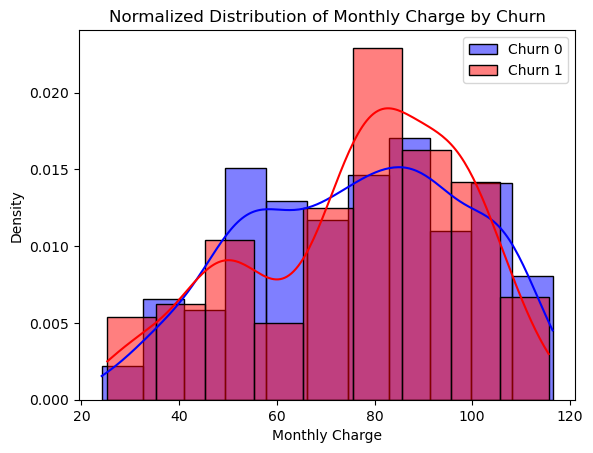

In [114]:
# Separate data for Churn = 0 and Churn = 1
data_churn_0 = charges[charges['Churn Value'] == 0]['Monthly Charge']
data_churn_1 = charges[charges['Churn Value'] == 1]['Monthly Charge']

# Normalize the histograms
sns.histplot(data_churn_0, kde=True, label='Churn 0', color='blue', stat="density")
sns.histplot(data_churn_1, kde=True, label='Churn 1', color='red', stat="density")

plt.xlabel('Monthly Charge')
plt.ylabel('Density')
plt.title('Normalized Distribution of Monthly Charge by Churn')
plt.legend()
plt.show()

## Streaming TV_Yes

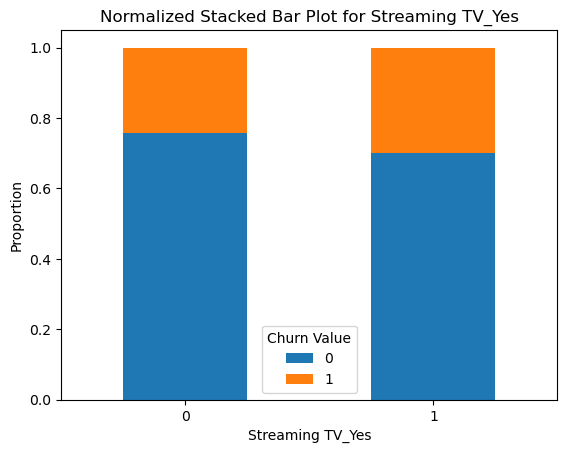

In [115]:
normalized_data = customer_churn_data.groupby([ 'Streaming TV_Yes', 'Churn Value']).size().unstack().apply(lambda row: row / row.sum(), axis=1)

normalized_data.plot(kind='bar',stacked=True)
plt.title('Normalized Stacked Bar Plot for Streaming TV_Yes')
plt.xlabel('Streaming TV_Yes')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Churn Value')
plt.show()

## correlation
## Correlation analysis is primarily used to understand the linear relationships between pairs of features

In [116]:
corr=customer_churn_data.corr()
corr

,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform,Churn Value
Number of Dependents,1.000000,0.016493,0.029081,-0.024271,-0.017848,0.036340,0.005840,-0.168152,0.324205,-0.015491,0.278003,0.108237,-0.007324,0.129966,-0.131837,0.022535,0.014023,-0.014436,0.068966,0.309319,-0.010149,-0.030307,-0.153137,0.007312,0.008256,-0.139224,0.041977,0.001721,-0.019925,0.022094,-0.052981,-0.065215,-0.033048,-0.113853,-0.106814,-0.081052,-0.015211,0.146790,-0.218780
Zip Code,0.016493,1.000000,0.894769,-0.790564,-0.561491,-0.001204,0.021058,-0.012995,-0.001577,-0.424062,0.001463,0.007146,0.005894,-0.010998,-0.010775,0.001978,-0.003797,-0.014550,0.005063,-0.000907,-0.008830,-0.021183,-0.016755,0.002830,-0.005964,-0.010678,0.009159,-0.004058,0.005999,0.016752,0.003005,0.003341,0.003039,-0.012157,-0.014488,-0.005228,0.037234,0.016740,-0.016289
Latitude,0.029081,0.894769,1.000000,-0.885979,-0.543441,-0.009920,0.013070,-0.019103,0.001059,-0.434797,0.018715,0.011963,0.002631,-0.027676,-0.030325,-0.002784,-0.009901,-0.013233,0.008029,0.002449,-0.019188,-0.028369,-0.033101,0.004047,0.001388,-0.031360,0.011353,-0.001735,0.000240,0.015383,-0.003772,-0.004993,-0.005178,-0.026940,-0.026376,-0.012731,0.015335,0.028712,-0.041546
Longitude,-0.024271,-0.790564,-0.885979,1.000000,0.407338,0.011302,-0.013217,0.013202,0.003638,0.296288,-0.009893,-0.009672,-0.004341,0.030979,0.028429,0.003811,-0.000597,0.010461,-0.006923,0.003300,0.017360,0.025316,0.037008,0.005257,0.007509,0.020940,-0.013267,0.011237,0.004533,-0.014283,0.012484,0.002810,0.003570,0.029746,0.024070,0.018201,-0.001948,-0.024302,0.024052
city_transform,-0.017848,-0.561491,-0.543441,0.407338,1.000000,0.010497,0.002503,0.005184,-0.022182,0.584524,-0.037003,-0.018476,-0.003623,0.006445,0.009789,-0.014517,0.044643,0.020897,-0.019762,-0.019793,0.010256,0.009268,0.012351,0.007382,-0.003340,0.008326,-0.003997,0.002419,-0.015703,-0.014348,0.006892,0.000733,0.003663,0.007385,0.008361,0.018370,-0.021440,-0.029046,0.044999
Under 30_Yes,0.036340,-0.001204,-0.009920,0.011302,0.010497,1.000000,-0.002962,-0.219216,0.015140,0.035587,0.023400,-0.000317,0.009360,0.522598,-0.044466,-0.014157,-0.012096,0.012301,-0.001714,0.016476,-0.008823,-0.035287,-0.035784,0.019741,0.024665,-0.063727,0.031760,0.005104,0.003904,0.021477,-0.016436,-0.009819,0.123590,-0.031771,-0.038867,-0.045506,0.016297,-0.005644,-0.054604
Gender_Male,0.005840,0.021058,0.013070,-0.013217,0.002503,-0.002962,1.000000,-0.001874,-0.001808,0.010577,-0.009074,0.005162,0.010130,-0.014065,-0.014569,-0.000152,0.004725,-0.001921,0.011092,-0.004176,-0.006488,-0.008414,-0.006026,-0.011404,0.016180,-0.011433,-0.017021,-0.013773,-0.002105,-0.009212,-0.008393,-0.010487,-0.007625,-0.000648,-0.011754,-0.012625,-0.001663,-0.000430,-0.008612
Senior Citizen_Yes,-0.168152,-0.012995,-0.019103,0.013202,0.005184,-0.219216,-0.001874,1.000000,0.016479,-0.006004,-0.026575,0.016299,-0.000713,-0.101874,0.220173,0.102907,0.028565,0.032917,0.010534,0.009714,0.008576,0.142948,0.182742,-0.047290,-0.074427,0.246501,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,-0.147823,0.140179,0.156530,0.149732,-0.049865,0.032250,0.150889
Married_Yes,0.324205,-0.001577,0.001059,0.003638,-0.022182,0.015140,-0.001808,0.016479,1.000000,-0.007894,0.672867,0.380394,0.010215,0.056745,0.096848,0.317777,0.040142,0.017882,0.264

# important positive corr

In [117]:
corr=customer_churn_data.corr()
correlation_threshold=0.05
positive_corr=corr[corr["Churn Value"]>0 ].sort_values(by="Churn Value",ascending=False)
positive_corr[positive_corr["Churn Value"]>=correlation_threshold]



,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform,Churn Value
Churn Value,-0.218780,-0.016289,-0.041546,0.024052,0.044999,-0.054604,-0.008612,0.150889,-0.150448,0.051655,-0.286540,-0.352861,0.008120,0.048868,0.193356,-0.198546,-0.033709,0.007139,-0.223756,-0.149122,0.011942,0.040102,0.227890,-0.007238,-0.099716,0.279623,-0.171226,-0.082255,-0.066160,-0.164674,0.063228,0.061382,0.045587,0.166545,0.191825,0.188733,0.056348,-0.435398,1.000000
Internet Type_Fiber Optic,-0.139224,-0.010678,-0.031360,0.020940,0.008326,-0.063727,-0.011433,0.246501,-0.002298,0.006967,-0.055884,0.026816,0.145236,0.191512,0.774253,0.364414,0.022214,0.063250,0.106239,-0.006583,0.284934,0.359797,0.457658,-0.318056,-0.481710,1.000000,-0.024751,0.167258,0.175230,-0.015673,0.322701,0.316989,0.245256,0.349348,0.320088,0.289346,-0.112135,-0.193237,0.279623
Internet Service_Yes,-0.153137,-0.016755,-0.033101,0.037008,0.012351,-0.035784,-0.006026,0.182742,-0.000615,0.013540,-0.038984,0.038582,-0.068605,0.528450,0.763557,0.375269,0.020515,0.143736,-0.013128,0.002842,-0.172209,0.210564,1.000000,0.192227,0.291136,0.457658,0.333403,0.381593,0.380754,0.336298,0.415552,0.418675,0.388693,0.755734,0.321013,0.272517,-0.090333,-0.202376,0.227890
Monthly Charge,-0.131837,-0.010775,-0.030325,0.028429,0.009789,-0.044466,-0.014569,0.220173,0.096848,0.009602,0.028173,0.247582,0.138396,0.391787,1.000000,0.651236,0.033482,0.126244,0.246300,0.094101,0.247398,0.490434,0.763557,-0.054473,-0.121034,0.774253,0.296594,0.441780,0.482692,0.338304,0.629603,0.627429,0.536270,0.582484,0.352150,0.293768,-0.136941,-0.040841,0.193356
Paperless Billing_Yes,-0.106814,-0.014488,-0.026376,0.024070,0.008361,-0.038867,-0.011754,0.156530,-0.014877,0.002423,-0.044888,0.005743,0.018673,0.142999,0.352150,0.158442,0.003966,0.038718,0.018924,-0.011095,0.016505,0.163530,0.321013,-0.010343,-0.054104,0.320088,-0.003636,0.126735,0.103797,0.037880,0.223841,0.211716,0.167172,0.245215,1.000000,0.184889,-0.061013,-0.149583,0.191825
Payment Method_Bank Withdrawal,-0.081052,-0.005228,-0.012731,0.018201,0.018370,-0.045506,-0.012625,0.149732,0.012478,0.014047,-0.041590,0.004239,0.012615,0.114748,0.293768,0.098382,0.030761,0.050436,0.009046,0.009593,0.009200,0.142339,0.272517,-0.034262,-0.047126,0.289346,-0.027536,0.072043,0.066008,-0.024839,0.175944,0.171613,0.130373,0.197092,0.184889,1.000000,-0.268560,-0.137895,0.188733
Unlimited Data_Yes,-0.113853,-0.012157,-0.026940,0.029746,0.007385,-0.031771,-0.000648,0.140179,0.018792,0.007491,-0.005813,0.031194,-0.053273,0.395209,0.582484,0.288220,0.011101,-0.392720,-0.009185,0.019014,-0.122395,0.159669,0.755734,0.146346,0.215137,0.349348,0.265037,0.283855,0.296619,0.251496,0.323256,0.318453,0.297011,1.000000,0.245215,0.197092,-0.065785,-0.141168,0.166545
Senior Citizen_Yes,-0.168152,-0.012995,-0.019103,0.013202,0.005184,-0.219216,-0.001874,1.000000,0.016479,-0.006004,-0.026575,0.016299,-0.000713,-0.101874,0.220173,0.102907,0.028565,0.032917,0.010534,0.009714,0.008576,0.142948,0.182742,-0.047290,-0.074427,0.246501,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,-0.147823,0.140179,0.156530,0.149732,-0.049865,0.032250,0.150889
Streaming TV_Yes,-0.052981,0.003005,-0.003772,0.012484,0.006892,-0.016436,-0.008393,0.105378,0.124666,0.001496,0.079687,0.279928,0.001641,0.227715,0.629603,0.515217,0.021796,0

In [118]:
positive_corr[(positive_corr.index[1:4])][positive_corr.index=="Churn Value" ]

,Internet Type_Fiber Optic,Internet Service_Yes,Monthly Charge
Churn Value,0.279623,0.22789,0.193356


# least important positive corr

In [119]:
corr=customer_churn_data.corr()
correlation_threshold=0.05
positive_corr=corr[corr["Churn Value"]>0 ].sort_values(by="Churn Value",ascending=False)
positive_corr[positive_corr["Churn Value"]<correlation_threshold]


,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform,Churn Value
Avg Monthly GB Download,0.129966,-0.010998,-0.027676,0.030979,0.006445,0.522598,-0.014065,-0.101874,0.056745,0.024759,0.038575,0.049119,-0.030455,1.000000,0.391787,0.223268,0.002397,0.088939,0.011373,0.055003,-0.102748,0.091679,0.528450,0.131698,0.189763,0.191512,0.234738,0.229254,0.225877,0.223924,0.227715,0.231211,0.323998,0.395209,0.142999,0.114748,-0.043116,-0.093588,0.048868
Streaming Music_Yes,-0.033048,0.003039,-0.005178,0.003570,0.003663,0.123590,-0.007625,-0.147823,0.088700,0.018374,0.051349,0.238082,0.008044,0.323998,0.536270,0.440462,0.003212,0.079644,0.151411,0.089917,-0.039252,0.193362,0.388693,0.044955,0.057077,0.245256,0.195604,0.245559,0.349208,0.276157,0.455387,0.848528,1.000000,0.297011,0.167172,0.130373,-0.070569,0.083357,0.045587
city_transform,-0.017848,-0.561491,-0.543441,0.407338,1.000000,0.010497,0.002503,0.005184,-0.022182,0.584524,-0.037003,-0.018476,-0.003623,0.006445,0.009789,-0.014517,0.044643,0.020897,-0.019762,-0.019793,0.010256,0.009268,0.012351,0.007382,-0.003340,0.008326,-0.003997,0.002419,-0.015703,-0.014348,0.006892,0.000733,0.003663,0.007385,0.008361,0.018370,-0.021440,-0.029046,0.044999
Multiple Lines_Yes,-0.030307,-0.021183,-0.028369,0.025316,0.009268,-0.035287,-0.008414,0.142948,0.142057,0.003762,0.078080,0.332101,0.136004,0.091679,0.490434,0.468615,0.045491,0.064443,0.323165,0.132641,0.279690,1.000000,0.210564,-0.097305,-0.141726,0.359797,0.098108,0.202237,0.201137,0.100571,0.257152,0.258751,0.193362,0.159669,0.163530,0.142339,-0.091576,0.120475,0.040102
Longitude,-0.024271,-0.790564,-0.885979,1.000000,0.407338,0.011302,-0.013217,0.013202,0.003638,0.296288,-0.009893,-0.009672,-0.004341,0.030979,0.028429,0.003811,-0.000597,0.010461,-0.006923,0.003300,0.017360,0.025316,0.037008,0.005257,0.007509,0.020940,-0.013267,0.011237,0.004533,-0.014283,0.012484,0.002810,0.003570,0.029746,0.024070,0.018201,-0.001948,-0.024302,0.024052
Phone Service_Yes,-0.010149,-0.008830,-0.019188,0.017360,0.010256,-0.008823,-0.006488,0.008576,0.017706,0.009678,0.009947,0.008271,0.486673,-0.102748,0.247398,0.113106,0.006331,-0.030620,0.289728,0.015418,1.000000,0.279690,-0.172209,-0.221316,-0.332029,0.284934,-0.092893,-0.052312,-0.071227,-0.096340,-0.022574,-0.032959,-0.039252,-0.122395,0.016505,0.009200,-0.028975,0.002698,0.011942
Avg Monthly Long Distance Charges,-0.007324,0.005894,0.002631,-0.004341,-0.003623,0.009360,0.010130,-0.000713,0.010215,-0.018669,0.006336,0.014596,1.000000,-0.030455,0.138396,0.069500,-0.018644,0.002414,0.599828,0.008702,0.486673,0.136004,-0.068605,-0.095124,-0.164057,0.145236,-0.028108,-0.013909,-0.031869,-0.048217,0.001641,0.003612,0.008044,-0.053273,0.018673,0.012615,-0.016028,-0.002515,0.008120
Total Extra Data Charges,-0.014436,-0.014550,-0.013233,0.010461,0.020897,0.012301,-0.001921,0.032917,0.017882,0.012031,0.000350,0.082266,0.002414,0.088939,0.126244,0.121859,0.016755,1.000000,0.058871,0.020150,-0.030620,0.064443,0.143736,0.011325,0.057213,0.063250,0.058889,0.095852,0.073985,0.087941,0.072300,0.094445,0.079644,-0.392720,0.038718,0.050436,-0.033375,0.001523,0.007139


# important negative corr

In [120]:
corr=customer_churn_data.corr()
correlation_threshold= -0.05
positive_corr=corr[corr["Churn Value"]<0].sort_values(by="Churn Value",ascending=True)
positive_corr[positive_corr["Churn Value"]<=correlation_threshold]



,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform,Churn Value
Contract_transform,0.146790,0.016740,0.028712,-0.024302,-0.029046,-0.005644,-0.000430,0.032250,0.277700,-0.014821,0.290369,0.646632,-0.002515,-0.093588,-0.040841,0.440966,0.050719,0.001523,0.424220,0.270105,0.002698,0.120475,-0.202376,-0.001805,0.030445,-0.193237,0.228371,0.159355,0.217698,0.269251,0.106575,0.116055,0.083357,-0.141168,-0.149583,-0.137895,-0.051972,1.000000,-0.435398
Tenure in Months,0.108237,0.007146,0.011963,-0.009672,-0.018476,-0.000317,0.005162,0.016299,0.380394,-0.012104,0.326975,1.000000,0.014596,0.049119,0.247582,0.826074,0.059021,0.082266,0.674149,0.361844,0.008271,0.332101,0.038582,-0.006191,0.010884,0.026816,0.327543,0.360558,0.360935,0.324554,0.279928,0.285926,0.238082,0.031194,0.005743,0.004239,-0.129776,0.646632,-0.352861
Number of Referrals,0.278003,0.001463,0.018715,-0.009893,-0.037003,0.023400,-0.009074,-0.026575,0.672867,-0.007702,1.000000,0.326975,0.006336,0.038575,0.028173,0.250378,0.024756,0.000350,0.216190,0.708291,0.009947,0.078080,-0.038984,0.005422,0.023283,-0.055884,0.142416,0.112369,0.116695,0.107725,0.079687,0.057821,0.051349,-0.005813,-0.044888,-0.041590,-0.047967,0.290369,-0.286540
Total Long Distance Charges,0.068966,0.005063,0.008029,-0.006923,-0.019762,-0.001714,0.011092,0.010534,0.264230,-0.018647,0.216190,0.674149,0.599828,0.011373,0.246300,0.610185,0.028113,0.058871,1.000000,0.250769,0.289728,0.323165,-0.013128,-0.067455,-0.085597,0.106239,0.200477,0.239873,0.210057,0.182076,0.182302,0.186478,0.151411,-0.009185,0.018924,0.009046,-0.098162,0.424220,-0.223756
Number of Dependents,1.000000,0.016493,0.029081,-0.024271,-0.017848,0.036340,0.005840,-0.168152,0.324205,-0.015491,0.278003,0.108237,-0.007324,0.129966,-0.131837,0.022535,0.014023,-0.014436,0.068966,0.309319,-0.010149,-0.030307,-0.153137,0.007312,0.008256,-0.139224,0.041977,0.001721,-0.019925,0.022094,-0.052981,-0.065215,-0.033048,-0.113853,-0.106814,-0.081052,-0.015211,0.146790,-0.218780
Total Charges,0.022535,0.001978,-0.002784,0.003811,-0.014517,-0.014157,-0.000152,0.102907,0.317777,-0.006436,0.250378,0.826074,0.069500,0.223268,0.651236,1.000000,0.039558,0.121859,0.610185,0.304199,0.113106,0.468615,0.375269,-0.031338,-0.037180,0.364414,0.411922,0.509507,0.522255,0.432146,0.515217,0.520130,0.440462,0.288220,0.158442,0.098382,-0.135690,0.440966,-0.198546
Online Security_Yes,0.041977,0.009159,0.011353,-0.013267,-0.003997,0.031760,-0.017021,-0.038653,0.143106,0.004764,0.142416,0.327543,-0.028108,0.234738,0.296594,0.411922,0.008190,0.058889,0.200477,0.139510,-0.092893,0.098108,0.333403,0.148084,0.240403,-0.024751,1.000000,0.283832,0.275438,0.354931,0.176207,0.187398,0.195604,0.265037,-0.003636,-0.027536,-0.029513,0.228371,-0.171226
Premium Tech Support_Yes,0.022094,0.016752,0.015383,-0.014283,-0.014348,0.021477,-0.009212,-0.060625,0.119999,-0.008229,0.107725,0.324554,-0.048217,0.223924,0.338304,0.432146,0.034823,0.087941,0.182076,0.121772,-0.096340,0.100571,0.336298,0.152446,0.229289,-0.015673,0.354931,0.294233,0.333313,1.000000,0.278070,0.279358,0.276157,0.251496,0.037880,-0.024839,-0.036790,0.269251,-0.164674
Married_Yes,0.324205,-0.001577,0.001059,0.003638,-0.022182,0.015140,-0.001808,0.016479,1.000000,-0.007894,0.672867,0.380394,0.010215,0.056745,0.096848,0.317777,0.040142,0.017882,0.264230

# least important negative corr

In [121]:
corr=customer_churn_data.corr()
correlation_threshold= -0.05
positive_corr=corr[corr["Churn Value"]<0].sort_values(by="Churn Value",ascending=True)
positive_corr[positive_corr["Churn Value"]>correlation_threshold]


,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform,Churn Value
Latitude,0.029081,0.894769,1.000000,-0.885979,-0.543441,-0.009920,0.013070,-0.019103,0.001059,-0.434797,0.018715,0.011963,0.002631,-0.027676,-0.030325,-0.002784,-0.009901,-0.013233,0.008029,0.002449,-0.019188,-0.028369,-0.033101,0.004047,0.001388,-0.031360,0.011353,-0.001735,0.000240,0.015383,-0.003772,-0.004993,-0.005178,-0.026940,-0.026376,-0.012731,0.015335,0.028712,-0.041546
Total Refunds,0.014023,-0.003797,-0.009901,-0.000597,0.044643,-0.012096,0.004725,0.028565,0.040142,0.019639,0.024756,0.059021,-0.018644,0.002397,0.033482,0.039558,1.000000,0.016755,0.028113,0.038250,0.006331,0.045491,0.020515,-0.013296,0.004102,0.022214,0.008190,0.016855,0.026038,0.034823,0.021796,0.013587,0.003212,0.011101,0.003966,0.030761,-0.023992,0.050719,-0.033709
Zip Code,0.016493,1.000000,0.894769,-0.790564,-0.561491,-0.001204,0.021058,-0.012995,-0.001577,-0.424062,0.001463,0.007146,0.005894,-0.010998,-0.010775,0.001978,-0.003797,-0.014550,0.005063,-0.000907,-0.008830,-0.021183,-0.016755,0.002830,-0.005964,-0.010678,0.009159,-0.004058,0.005999,0.016752,0.003005,0.003341,0.003039,-0.012157,-0.014488,-0.005228,0.037234,0.016740,-0.016289
Gender_Male,0.005840,0.021058,0.013070,-0.013217,0.002503,-0.002962,1.000000,-0.001874,-0.001808,0.010577,-0.009074,0.005162,0.010130,-0.014065,-0.014569,-0.000152,0.004725,-0.001921,0.011092,-0.004176,-0.006488,-0.008414,-0.006026,-0.011404,0.016180,-0.011433,-0.017021,-0.013773,-0.002105,-0.009212,-0.008393,-0.010487,-0.007625,-0.000648,-0.011754,-0.012625,-0.001663,-0.000430,-0.008612
Internet Type_Cable,0.007312,0.002830,0.004047,0.005257,0.007382,0.019741,-0.011404,-0.047290,0.002717,0.001068,0.005422,-0.006191,-0.095124,0.131698,-0.054473,-0.031338,-0.013296,0.011325,-0.067455,0.009100,-0.221316,-0.097305,0.192227,1.000000,-0.202329,-0.318056,0.148084,0.072029,0.071916,0.152446,0.025336,0.021726,0.044955,0.146346,-0.010343,-0.034262,0.041898,-0.001805,-0.007238


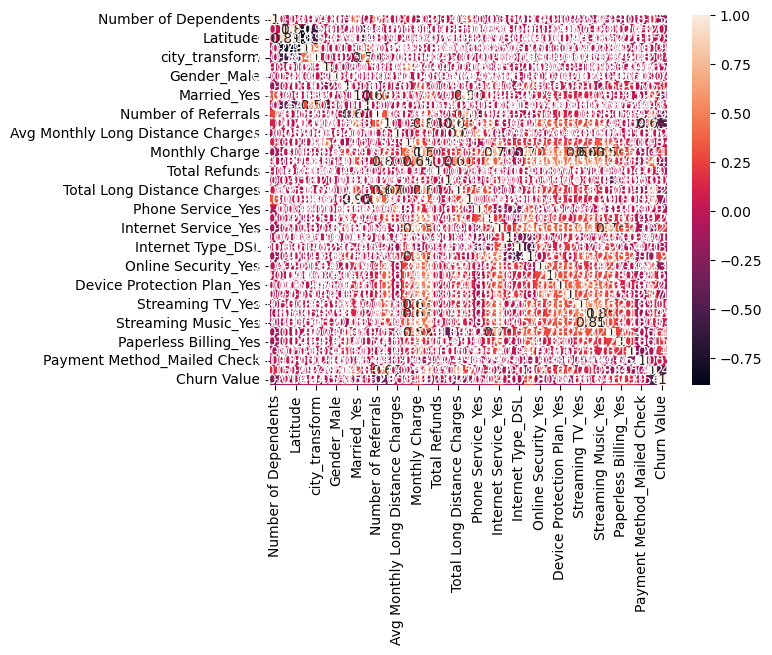

In [122]:
sns.heatmap(corr,annot=True)
plt.rcParams["figure.figsize"]=(60,40)

plt.show()

In [123]:
churn_value = customer_churn_data.copy()



In [124]:
churn_value

,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform,Churn Value
0,0,90022,34.023810,-118.156582,1,0,1,1,0,68701,0,1,0.00,8,39.65,39.65,0.0,20,0.00,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1
1,0,90022,34.023810,-118.156582,1,0,1,0,1,68701,5,72,42.55,18,72.10,5016.65,0.0,0,3063.60,1,1,1,1,0,1,0,1,1,1,1,0,0,0,1,0,0,0,2,0
2,0,90022,34.023810,-118.156582,1,0,0,0,0,68701,0,1,7.11,26,75.55,75.55,0.0,0,7.11,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
3,3,90022,34.023810,-118.156582,1,0,1,0,1,68701,4,66,0.00,25,56.75,3708.40,0.0,0,0.00,1,0,0,1,1,0,0,0,1,1,0,1,1,1,1,1,0,0,2,0
4,0,90022,34.023810,-118.156582,1,1,0,0,0,68701,0,7,36.49,42,94.05,633.45,0.0,0,255.43,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,91934,32.649787,-116.223700,0,1,0,0,1,699,6,1,16.06,59,53.55,53.55,0.0,0,16.06,1,1,0,1,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0
7039,0,92105,32.741859,-117.090353,1,0,1,0,1,73006,1,67,23.13,24,109.90,7332.40,0.0,0,1549.71,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,0,0,1,0
7040,3,92105,32.741859,-117.090353,1,0,1,0,1,73006,8,9,23.42,30,102.60,897.75,0.0,0,210.78,1,1,1,1,0,0,1,0,1,1,0,1,1,1,1,1,0,0,0,0
7041,0,92250,32.811001,-115.152865,0,0,1,0,0,8062,0,26,37.69,30,84.30,2281.60,0.0,0,979.94,0,1,1,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0


# remove outlier and check normality

## to remove outlier only the unique words count more than 3 which means is continous number variables will be consider
## in addition, categorical variables like  'Zip Code', 'Latitude', 'Longitude' will not consider in this outlier removal section even though unique values more than 3

In [125]:
categorical=['Latitude', 'Longitude',
       'Zip Code']

In [126]:
columns_moreThan3=customer_churn_data.nunique().sort_values(ascending=False)[(customer_churn_data.nunique().sort_values(ascending=False)>3)].index

In [127]:
column_checkOutlier=[]
for column in columns_moreThan3.to_list():
    if (column not in categorical):
        column_checkOutlier.append(column)

In [128]:
column_checkOutlier

['Total Charges',
 'Total Long Distance Charges',
 'Avg Monthly Long Distance Charges',
 'Monthly Charge',
 'Population',
 'Total Refunds',
 'Tenure in Months',
 'Avg Monthly GB Download',
 'Total Extra Data Charges',
 'Number of Referrals',
 'Number of Dependents']

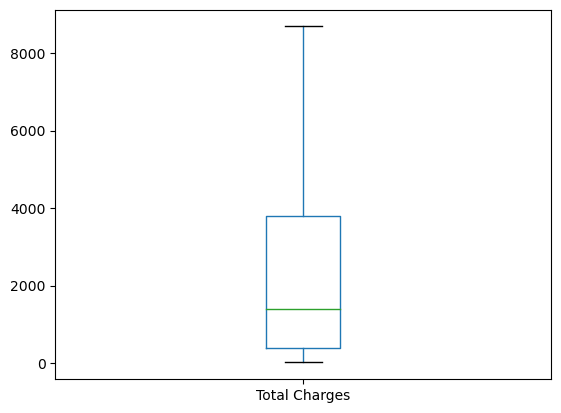

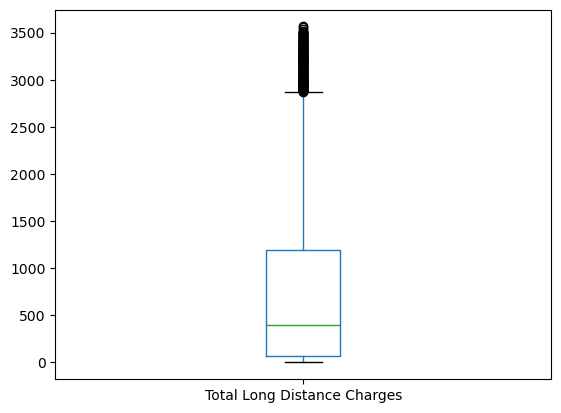

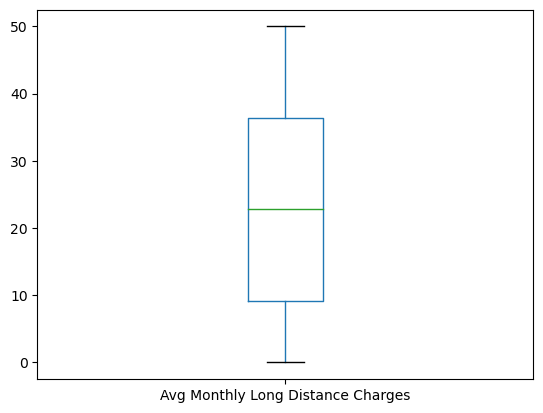

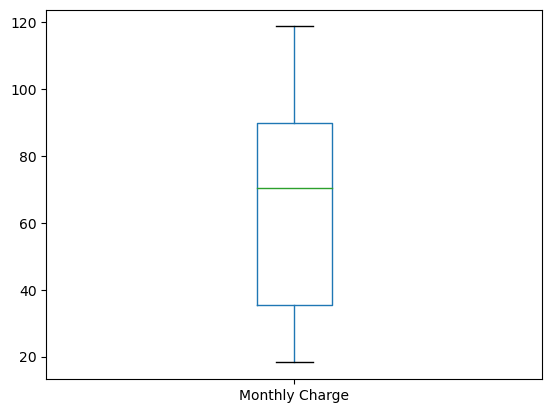

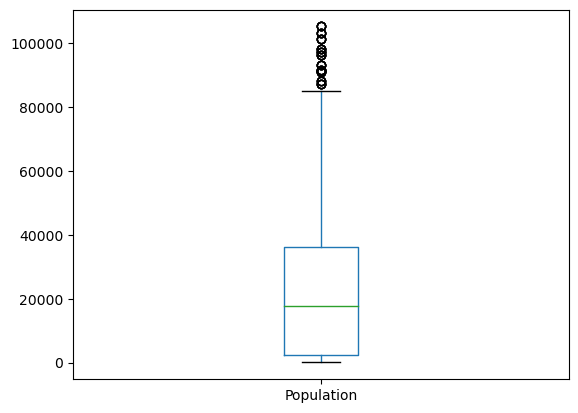

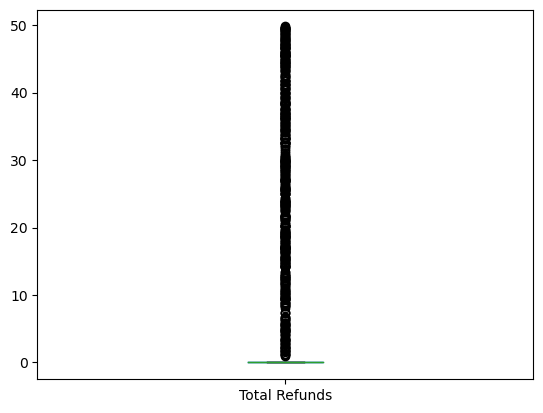

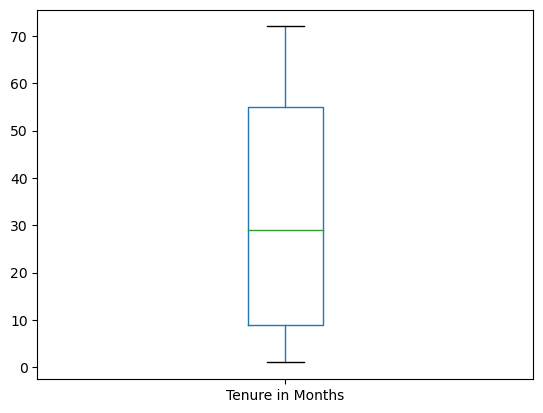

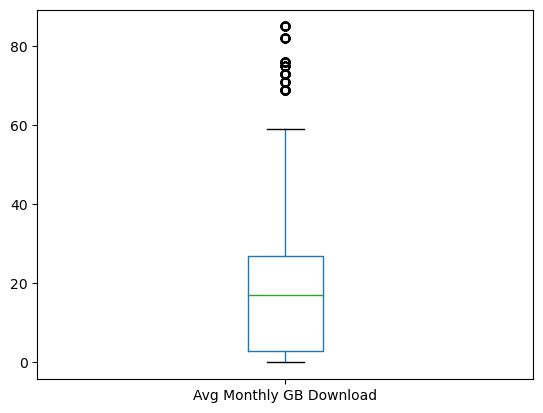

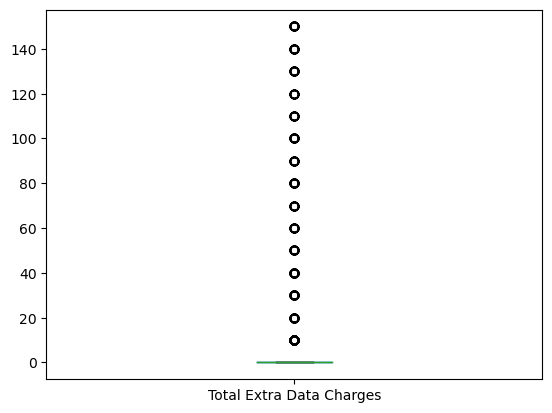

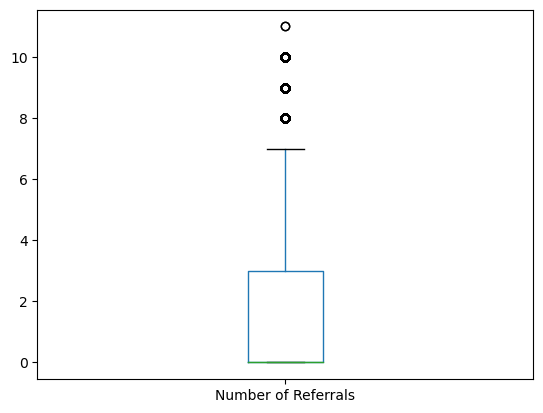

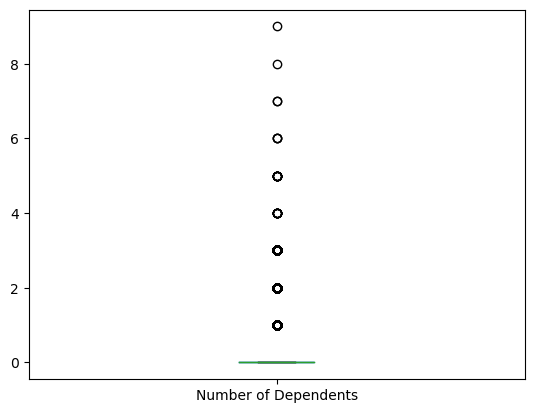

In [130]:
plt.rcParams['figure.figsize'] = [6.4, 4.8] 
for column in column_checkOutlier:
    churn_value.boxplot( column =[column], grid = False)
    
    plt.show()

# using percentiles
## Percentile-based Method: Calculate the  99th percentile of  data and consider any values above that percentile as outliers. This approach is particularly useful when dealing with highly skewed data.

In [131]:
upper_limit_funds= churn_value["Total Refunds"].quantile(0.99)
upper_limit_data_charges= churn_value["Total Extra Data Charges"].quantile(0.99)


In [132]:
print(f"upper_limit_refunds: {upper_limit_funds} ")
print(f"upper_limit_data_charges: {upper_limit_data_charges}")


upper_limit_refunds: 44.559 
upper_limit_data_charges: 140.0


In [133]:
churn_value[["Total Refunds"]][churn_value["Total Refunds"]>upper_limit_funds]

,Total Refunds
10,45.61
42,45.47
120,49.79
125,49.02
305,44.81
...,...
6914,47.73
6918,46.67
6920,47.02
6934,49.22


In [134]:
churn_value[["Total Extra Data Charges"]][churn_value["Total Extra Data Charges"]>upper_limit_data_charges]

,Total Extra Data Charges
32,150
366,150
526,150
676,150
774,150
899,150
929,150
1108,150
1132,150
1217,150


In [135]:
churn_value=churn_value[churn_value["Total Refunds"]<=upper_limit_funds]

In [136]:
churn_value=churn_value[churn_value["Total Extra Data Charges"]<=upper_limit_data_charges]

In [137]:
churn_value.shape

(6932, 39)

# apply z-score

In [138]:
final_column_checkOutlier = [ 'Total Long Distance Charges','Avg Monthly GB Download']

In [139]:
final_column_checkOutlier

['Total Long Distance Charges', 'Avg Monthly GB Download']

In [140]:
def removeOutlierForEachColumn2022(columns,df):
  
    for column in columns:
      
        try:
            if len(df[column].unique())==1:

                print(column)
                continue
            else:
               
                df["threshold"]= (df[[column]]-df[[column]].mean())/df[[column]].std()
                df= df[~((df["threshold"]>3 )|(df["threshold"]<-3))]
                #print(particularMonth.index.month[0])
                df.drop(columns="threshold",inplace=True)
        except:
            print(f"column {columns} std is 0")
    return df

In [141]:


churn_value =removeOutlierForEachColumn2022(final_column_checkOutlier,churn_value)

C:\Users\Win11\AppData\Local\Temp\ipykernel_8704\250163159.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns="threshold",inplace=True)
C:\Users\Win11\AppData\Local\Temp\ipykernel_8704\250163159.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["threshold"]= (df[[column]]-df[[column]].mean())/df[[column]].std()


In [142]:
churn_value


,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform,Churn Value
0,0,90022,34.023810,-118.156582,1,0,1,1,0,68701,0,1,0.00,8,39.65,39.65,0.0,20,0.00,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1
1,0,90022,34.023810,-118.156582,1,0,1,0,1,68701,5,72,42.55,18,72.10,5016.65,0.0,0,3063.60,1,1,1,1,0,1,0,1,1,1,1,0,0,0,1,0,0,0,2,0
2,0,90022,34.023810,-118.156582,1,0,0,0,0,68701,0,1,7.11,26,75.55,75.55,0.0,0,7.11,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
3,3,90022,34.023810,-118.156582,1,0,1,0,1,68701,4,66,0.00,25,56.75,3708.40,0.0,0,0.00,1,0,0,1,1,0,0,0,1,1,0,1,1,1,1,1,0,0,2,0
4,0,90022,34.023810,-118.156582,1,1,0,0,0,68701,0,7,36.49,42,94.05,633.45,0.0,0,255.43,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,91934,32.649787,-116.223700,0,1,0,0,1,699,6,1,16.06,59,53.55,53.55,0.0,0,16.06,1,1,0,1,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0
7039,0,92105,32.741859,-117.090353,1,0,1,0,1,73006,1,67,23.13,24,109.90,7332.40,0.0,0,1549.71,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,0,0,1,0
7040,3,92105,32.741859,-117.090353,1,0,1,0,1,73006,8,9,23.42,30,102.60,897.75,0.0,0,210.78,1,1,1,1,0,0,1,0,1,1,0,1,1,1,1,1,0,0,0,0
7041,0,92250,32.811001,-115.152865,0,0,1,0,0,8062,0,26,37.69,30,84.30,2281.60,0.0,0,979.94,0,1,1,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0


# see distribution

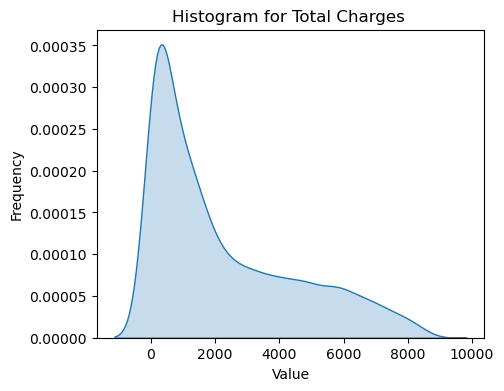

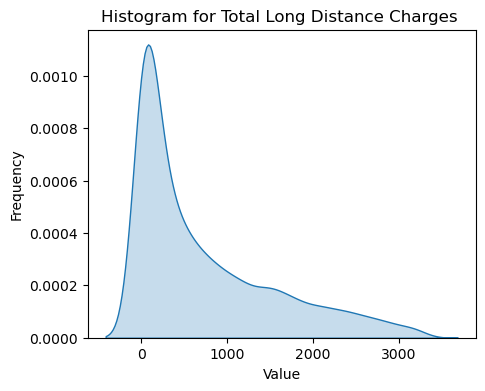

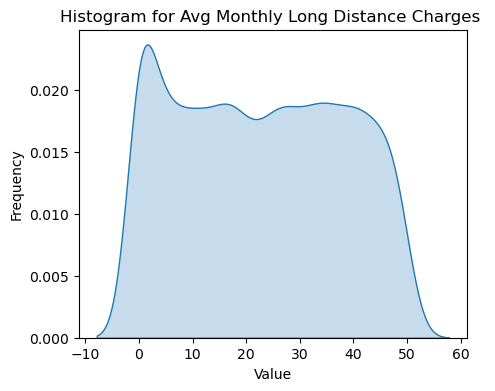

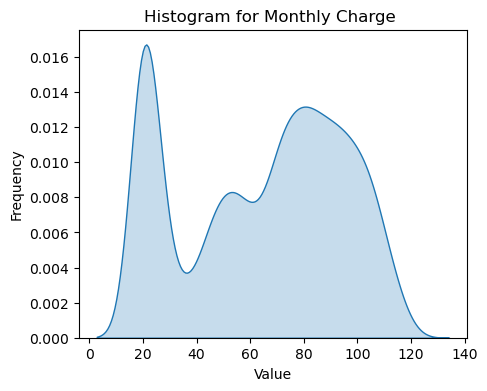

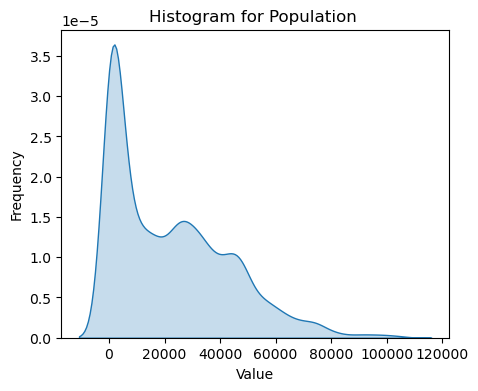

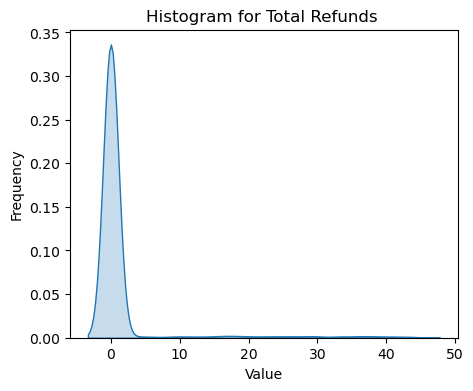

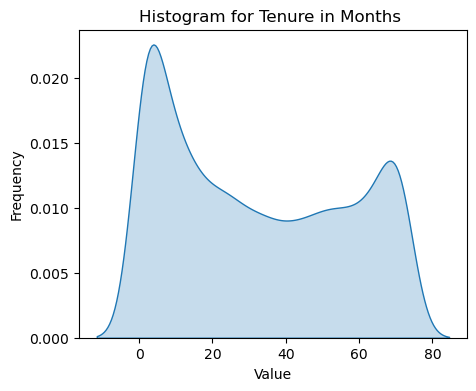

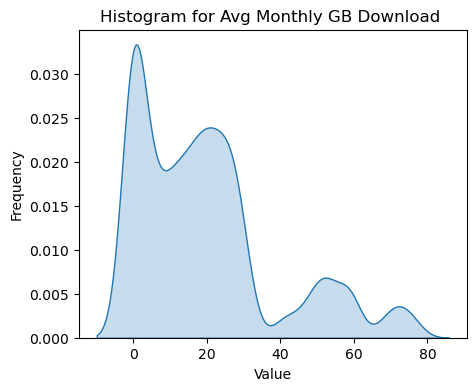

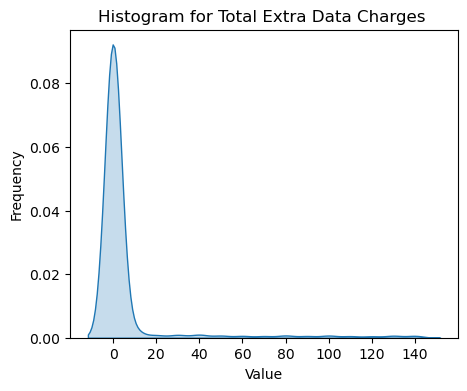

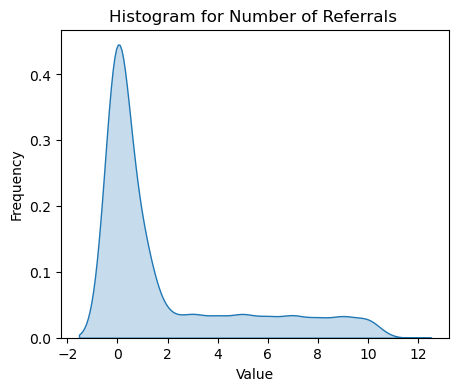

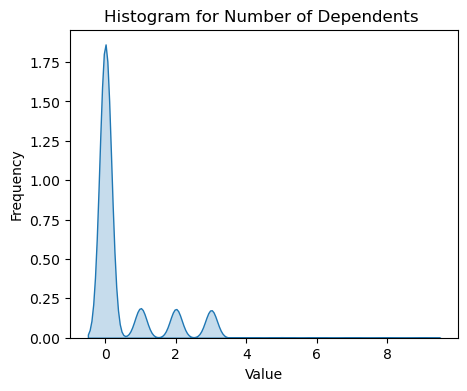

In [143]:
for i in column_checkOutlier:
    plt.figure(figsize=(5, 4))
    sns.kdeplot(churn_value[i],fill=True)
   # w,p =stats.shapiro(churn_value[i])
 
   # plt.title(f"Histogram for {i} and Shapiro p value: {p}")
    plt.title(f"Histogram for {i} ")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

# power transformation 

In [144]:
from sklearn.preprocessing import PowerTransformer

In [145]:

columns_to_transform = [
    'Total Charges', 'Total Long Distance Charges', 'Avg Monthly Long Distance Charges',
    'Monthly Charge', 'Population', 'Total Refunds', 'Tenure in Months',
    'Avg Monthly GB Download', 'Total Extra Data Charges', 'Number of Referrals',
    'Number of Dependents'
]


transform = PowerTransformer(method='yeo-johnson')


churn_value[columns_to_transform] = transform.fit_transform(churn_value[columns_to_transform])

In [146]:
churn_value

,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform,Churn Value
0,-0.546024,90022,34.023810,-118.156582,1,0,1,1,0,1.506304,-0.861994,-1.641818,-1.770674,-0.323360,-0.802459,-1.718172,-0.263975,3.016358,-1.779858,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1
1,-0.546024,90022,34.023810,-118.156582,1,0,1,0,1,1.506304,1.361582,1.355776,1.180823,0.284221,0.276955,1.168300,-0.263975,-0.331556,1.690517,1,1,1,1,0,1,0,1,1,1,1,0,0,0,1,0,0,0,2,0
2,-0.546024,90022,34.023810,-118.156582,1,0,0,0,0,1.506304,-0.861994,-1.641818,-0.946832,0.620829,0.388601,-1.504070,-0.263975,-0.331556,-1.409911,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
3,1.898090,90022,34.023810,-118.156582,1,0,1,0,1,1.506304,1.263454,1.217157,-1.770674,0.582945,-0.226284,0.870315,-0.263975,-0.331556,-1.779858,1,0,0,1,1,0,0,0,1,1,0,1,1,1,1,1,0,0,2,0
4,-0.546024,90022,34.023810,-118.156582,1,1,0,0,0,1.506304,-0.861994,-0.984804,0.886944,1.125153,0.979657,-0.490263,-0.263975,-0.331556,-0.163470,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.546024,91934,32.649787,-116.223700,0,1,0,0,1,-1.345872,1.432797,-1.641818,-0.272676,1.532179,-0.332705,-1.622824,-0.263975,-0.331556,-1.224304,1,1,0,1,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0
7039,-0.546024,92105,32.741859,-117.090353,1,0,1,0,1,1.577504,0.429714,1.240734,0.167886,0.544029,1.477291,1.575450,-0.263975,-0.331556,1.062184,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,0,0,1,0
7040,1.898090,92105,32.741859,-117.090353,1,0,1,0,1,1.577504,1.529548,-0.837024,0.184856,0.763238,1.249000,-0.266626,-0.263975,-0.331556,-0.264178,1,1,1,1,0,0,1,0,1,1,0,1,1,1,1,1,0,0,0,0
7041,-0.546024,92250,32.811001,-115.152865,0,0,1,0,0,-0.314589,-0.861994,0.025773,0.946449,0.763238,0.669671,0.435481,-0.263975,-0.331556,0.696151,0,1,1,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0


In [147]:

churn_value =removeOutlierForEachColumn2022(final_column_checkOutlier,churn_value)

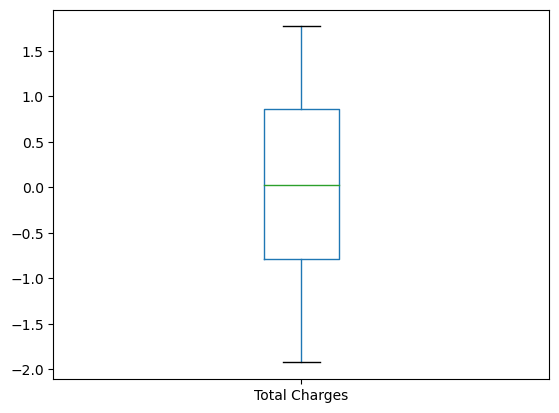

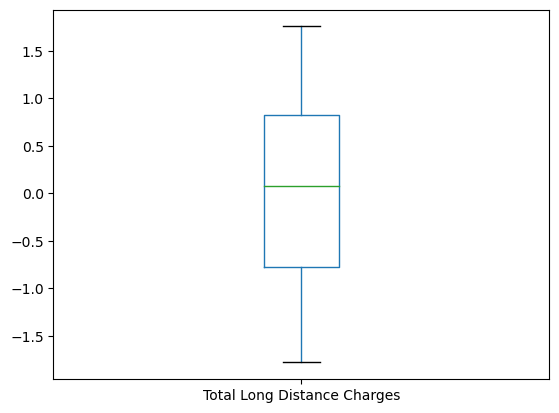

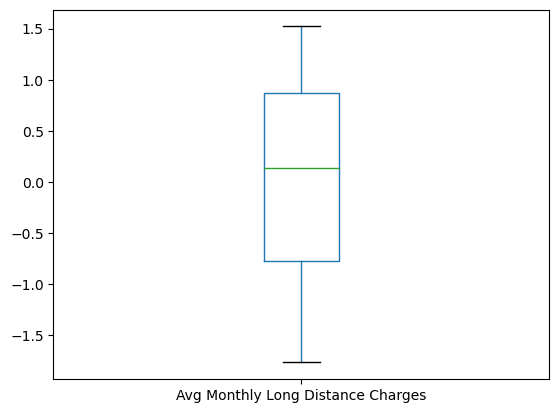

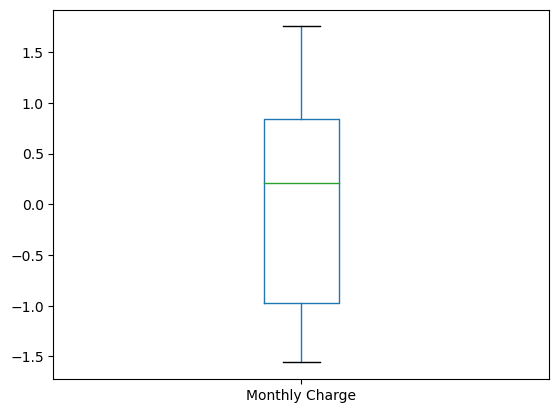

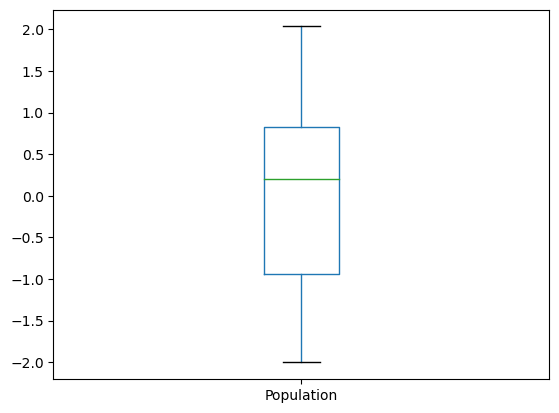

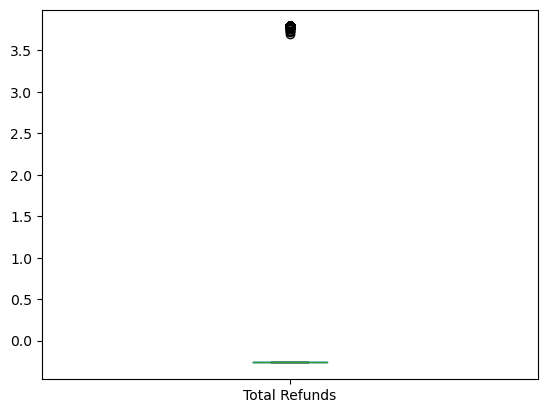

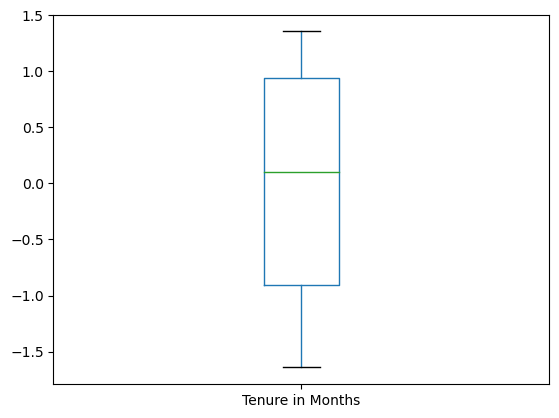

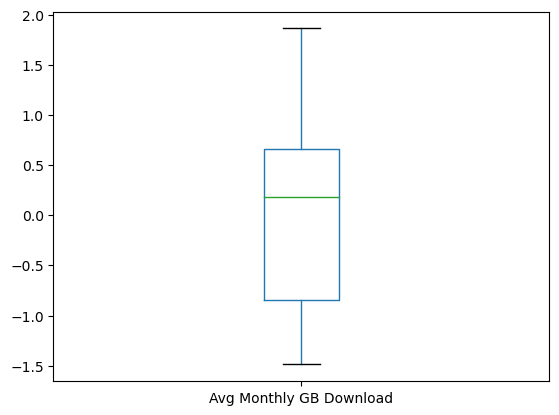

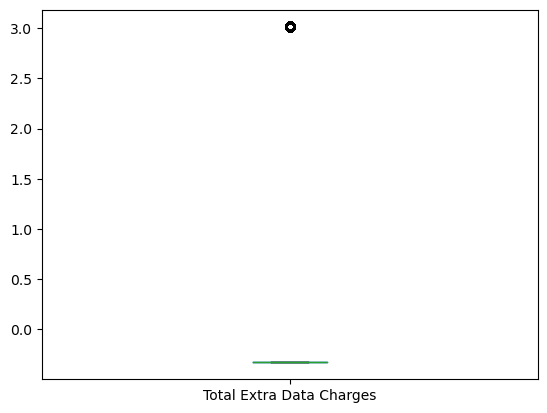

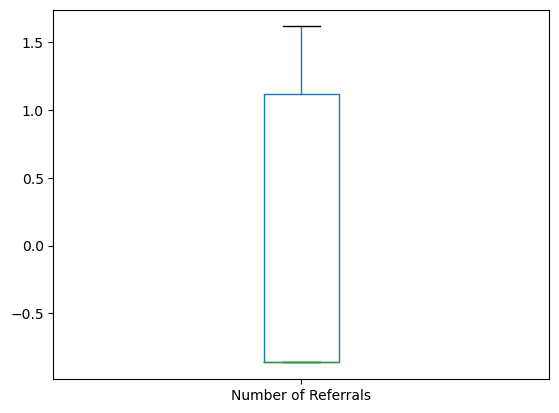

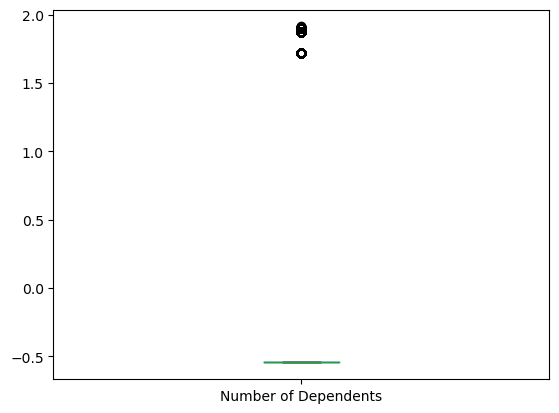

In [148]:
plt.rcParams['figure.figsize'] = [6.4, 4.8] 
for column in column_checkOutlier:
    churn_value.boxplot( column =[column], grid = False)
    
    plt.show()

D:\anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


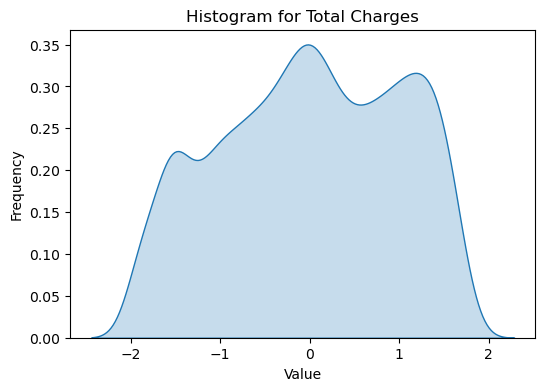

D:\anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


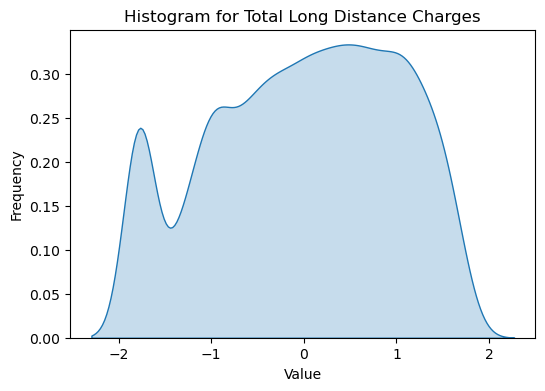

D:\anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


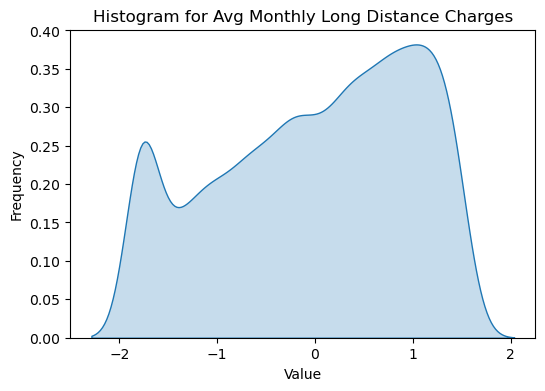

D:\anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


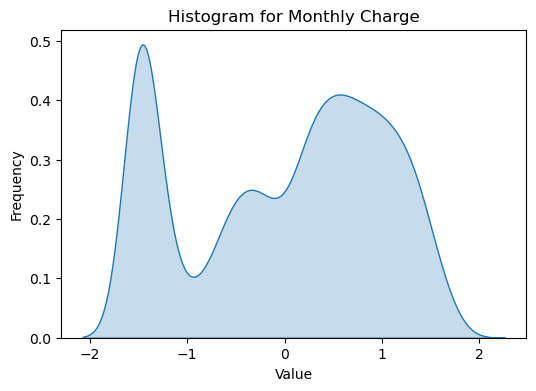

D:\anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


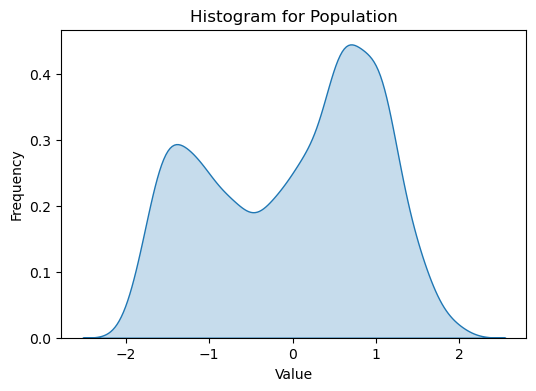

D:\anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


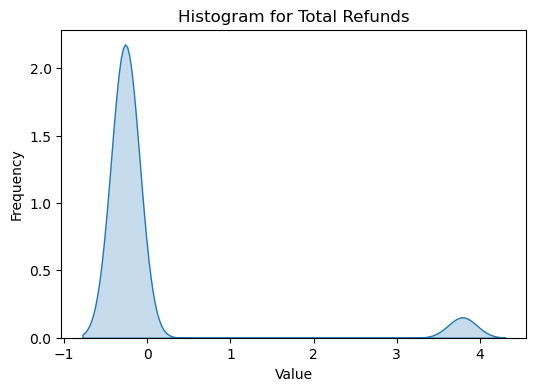

D:\anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


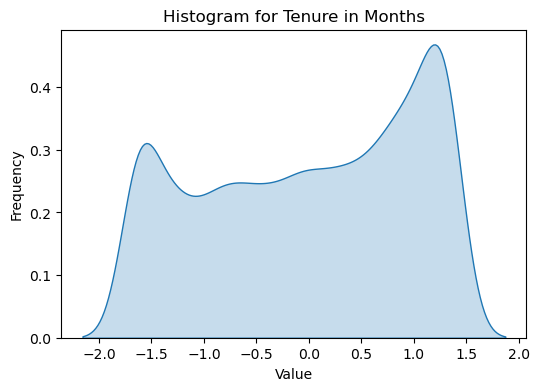

D:\anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


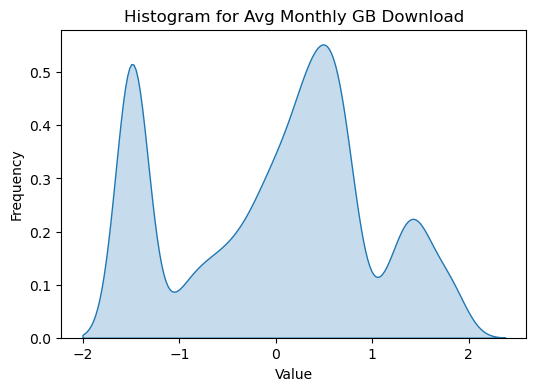

D:\anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


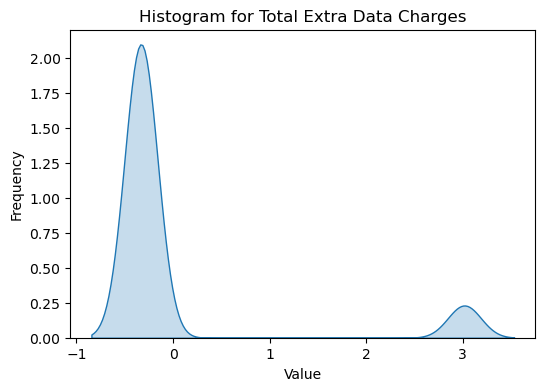

D:\anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


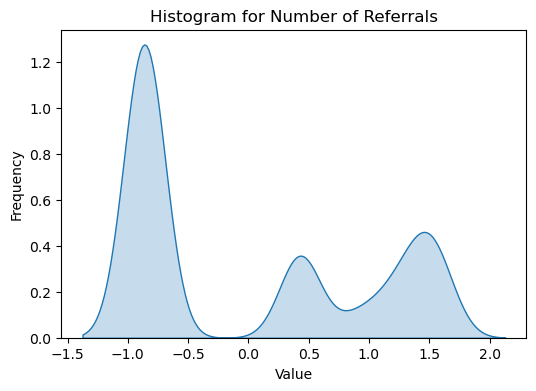

D:\anaconda\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


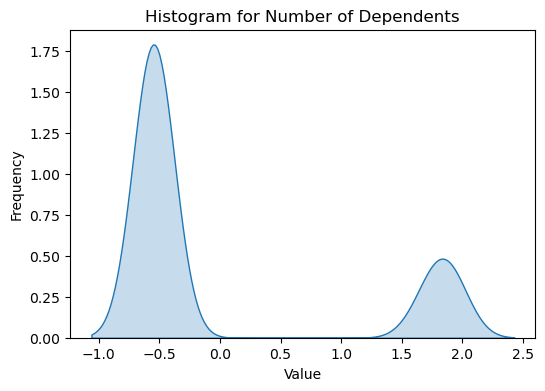

In [149]:
for i in column_checkOutlier:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(churn_value[i],fill=True)
    w,p =stats.shapiro(churn_value[i])
 
    plt.title(f"Histogram for {i} and Shapiro p value: {p}")
     
    plt.title(f"Histogram for {i}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

#  split to x and y

In [150]:
churn_value

,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform,Churn Value
0,-0.546024,90022,34.023810,-118.156582,1,0,1,1,0,1.506304,-0.861994,-1.641818,-1.770674,-0.323360,-0.802459,-1.718172,-0.263975,3.016358,-1.779858,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1
1,-0.546024,90022,34.023810,-118.156582,1,0,1,0,1,1.506304,1.361582,1.355776,1.180823,0.284221,0.276955,1.168300,-0.263975,-0.331556,1.690517,1,1,1,1,0,1,0,1,1,1,1,0,0,0,1,0,0,0,2,0
2,-0.546024,90022,34.023810,-118.156582,1,0,0,0,0,1.506304,-0.861994,-1.641818,-0.946832,0.620829,0.388601,-1.504070,-0.263975,-0.331556,-1.409911,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
3,1.898090,90022,34.023810,-118.156582,1,0,1,0,1,1.506304,1.263454,1.217157,-1.770674,0.582945,-0.226284,0.870315,-0.263975,-0.331556,-1.779858,1,0,0,1,1,0,0,0,1,1,0,1,1,1,1,1,0,0,2,0
4,-0.546024,90022,34.023810,-118.156582,1,1,0,0,0,1.506304,-0.861994,-0.984804,0.886944,1.125153,0.979657,-0.490263,-0.263975,-0.331556,-0.163470,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.546024,91934,32.649787,-116.223700,0,1,0,0,1,-1.345872,1.432797,-1.641818,-0.272676,1.532179,-0.332705,-1.622824,-0.263975,-0.331556,-1.224304,1,1,0,1,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0
7039,-0.546024,92105,32.741859,-117.090353,1,0,1,0,1,1.577504,0.429714,1.240734,0.167886,0.544029,1.477291,1.575450,-0.263975,-0.331556,1.062184,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,0,0,1,0
7040,1.898090,92105,32.741859,-117.090353,1,0,1,0,1,1.577504,1.529548,-0.837024,0.184856,0.763238,1.249000,-0.266626,-0.263975,-0.331556,-0.264178,1,1,1,1,0,0,1,0,1,1,0,1,1,1,1,1,0,0,0,0
7041,-0.546024,92250,32.811001,-115.152865,0,0,1,0,0,-0.314589,-0.861994,0.025773,0.946449,0.763238,0.669671,0.435481,-0.263975,-0.331556,0.696151,0,1,1,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0


In [151]:
X = churn_value.drop(columns=  'Churn Value')
y= churn_value[ 'Churn Value']

In [152]:
X

,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform
0,-0.546024,90022,34.023810,-118.156582,1,0,1,1,0,1.506304,-0.861994,-1.641818,-1.770674,-0.323360,-0.802459,-1.718172,-0.263975,3.016358,-1.779858,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0
1,-0.546024,90022,34.023810,-118.156582,1,0,1,0,1,1.506304,1.361582,1.355776,1.180823,0.284221,0.276955,1.168300,-0.263975,-0.331556,1.690517,1,1,1,1,0,1,0,1,1,1,1,0,0,0,1,0,0,0,2
2,-0.546024,90022,34.023810,-118.156582,1,0,0,0,0,1.506304,-0.861994,-1.641818,-0.946832,0.620829,0.388601,-1.504070,-0.263975,-0.331556,-1.409911,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0
3,1.898090,90022,34.023810,-118.156582,1,0,1,0,1,1.506304,1.263454,1.217157,-1.770674,0.582945,-0.226284,0.870315,-0.263975,-0.331556,-1.779858,1,0,0,1,1,0,0,0,1,1,0,1,1,1,1,1,0,0,2
4,-0.546024,90022,34.023810,-118.156582,1,1,0,0,0,1.506304,-0.861994,-0.984804,0.886944,1.125153,0.979657,-0.490263,-0.263975,-0.331556,-0.163470,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.546024,91934,32.649787,-116.223700,0,1,0,0,1,-1.345872,1.432797,-1.641818,-0.272676,1.532179,-0.332705,-1.622824,-0.263975,-0.331556,-1.224304,1,1,0,1,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0
7039,-0.546024,92105,32.741859,-117.090353,1,0,1,0,1,1.577504,0.429714,1.240734,0.167886,0.544029,1.477291,1.575450,-0.263975,-0.331556,1.062184,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,0,0,1
7040,1.898090,92105,32.741859,-117.090353,1,0,1,0,1,1.577504,1.529548,-0.837024,0.184856,0.763238,1.249000,-0.266626,-0.263975,-0.331556,-0.264178,1,1,1,1,0,0,1,0,1,1,0,1,1,1,1,1,0,0,0
7041,-0.546024,92250,32.811001,-115.152865,0,0,1,0,0,-0.314589,-0.861994,0.025773,0.946449,0.763238,0.669671,0.435481,-0.263975,-0.331556,0.696151,0,1,1,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0


In [153]:
y

0       1
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Name: Churn Value, Length: 6785, dtype: int64

## backward feature selection is generally preferred over a correlation matrix when my goal is to optimize a machine learning model's performance. It allows you to iteratively remove features based on their impact on the model's performance, which is more aligned with the goal of building predictive models.

### Considers Interactions: It accounts for interactions between features, which may not be captured by a simple correlation analysis.

### Account for Non-Linear Relationships: It can handle non-linear relationships between features and the target variable, whereas correlation analysis primarily captures linear relationships.


## reason not use correlation matrix to drop columns

### Feature Pairs Only: It only considers pairwise relationships between features and does not take into account the overall impact of features on the model.

### Limited to Linear Relationships: Correlation measures linear relationships, so it may miss important non-linear dependencies.

### No Consideration of Model Performance

# it’s almost rare that all the variables in the dataset are useful for building a model. Adding redundant variables reduces the model’s generalization capability and may also reduce the overall accuracy of a classifier. Furthermore, adding more variables to a model increases the overall complexity of the model.

## backward  feature elimination

In [275]:
xgbModel =xgb.XGBClassifier()

In [276]:
import sklearn

In [277]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [278]:
feature_selection = SFS(xgbModel, k_features=30, forward=False, scoring='f1')
feature_model=feature_selection.fit(X,y)

In [279]:
feature_importance_backward=pd.DataFrame.from_dict(feature_model.get_metric_dict()).T

In [280]:
feature_importance_backward

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
38,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7079407806191117, 0.7556179775280899, 0.613...",0.642854,"(Number of Dependents, Zip Code, Latitude, Lon...",0.097845,0.076126,0.038063
37,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","[0.7253333333333334, 0.7583333333333334, 0.630...",0.656077,"(Number of Dependents, Zip Code, Latitude, Lon...",0.094072,0.073191,0.036596
36,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15...","[0.7362784471218207, 0.7705382436260624, 0.645...",0.66741,"(Number of Dependents, Zip Code, Latitude, Lon...",0.094694,0.073676,0.036838
35,"(0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 1...","[0.7321668909825034, 0.7629733520336607, 0.632...",0.670222,"(Number of Dependents, Zip Code, Longitude, ci...",0.08393,0.0653,0.03265
34,"(0, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, ...","[0.7220708446866485, 0.7726638772663877, 0.641...",0.67491,"(Number of Dependents, Longitude, city_transfo...",0.079671,0.061987,0.030993
33,"(0, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, ...","[0.7220708446866485, 0.7726638772663877, 0.641...",0.67491,"(Number of Dependents, Longitude, city_transfo...",0.079671,0.061987,0.030993
32,"(0, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, ...","[0.7220708446866485, 0.7726638772663877, 0.641...",0.67491,"(Number of Dependents, Longitude, city_transfo...",0.079671,0.061987,0.030993
31,"(0, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, ...","[0.7220708446866485, 0.7726638772663877, 0.641...",0.67491,"(Number of Dependents, Longitude, city_transfo...",0.079671,0.061987,0.030993
30,"(0, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17,...","[0.7117241379310345, 0.767123287671233, 0.6486...",0.673302,"(Number of Dependents, city_transform, Under 3...",0.074852,0.058237,0.029119


In [284]:
feature_importance_backward[feature_importance_backward.index==33]['feature_names'].values

#no insulin, blood pressure,skinthickness

array([('Number of Dependents', 'Longitude', 'city_transform', 'Under 30_Yes', 'Gender_Male', 'Senior Citizen_Yes', 'Married_Yes', 'Number of Referrals', 'Tenure in Months', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Referred a Friend_Yes', 'Phone Service_Yes', 'Multiple Lines_Yes', 'Internet Type_Cable', 'Internet Type_DSL', 'Internet Type_Fiber Optic', 'Online Security_Yes', 'Online Backup_Yes', 'Device Protection Plan_Yes', 'Premium Tech Support_Yes', 'Streaming TV_Yes', 'Streaming Movies_Yes', 'Streaming Music_Yes', 'Unlimited Data_Yes', 'Paperless Billing_Yes', 'Payment Method_Bank Withdrawal', 'Payment Method_Mailed Check', 'Contract_transform')],
      dtype=object)

In [288]:
feature_importance=list(feature_importance_backward[feature_importance_backward.index==31]['feature_names'].values.tolist()[0])

  

In [289]:
for column in  churn_value.columns:
    if( column not in feature_importance):
        print(column)


Zip Code
Latitude
Population
Avg Monthly Long Distance Charges
Referred a Friend_Yes
Phone Service_Yes
Internet Service_Yes
Churn Value


In [287]:
customer_churn_data

,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform,Churn Value
0,0,90022,34.023810,-118.156582,1,0,1,1,0,68701,0,1,0.00,8,39.65,39.65,0.0,20,0.00,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1
1,0,90022,34.023810,-118.156582,1,0,1,0,1,68701,5,72,42.55,18,72.10,5016.65,0.0,0,3063.60,1,1,1,1,0,1,0,1,1,1,1,0,0,0,1,0,0,0,2,0
2,0,90022,34.023810,-118.156582,1,0,0,0,0,68701,0,1,7.11,26,75.55,75.55,0.0,0,7.11,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
3,3,90022,34.023810,-118.156582,1,0,1,0,1,68701,4,66,0.00,25,56.75,3708.40,0.0,0,0.00,1,0,0,1,1,0,0,0,1,1,0,1,1,1,1,1,0,0,2,0
4,0,90022,34.023810,-118.156582,1,1,0,0,0,68701,0,7,36.49,42,94.05,633.45,0.0,0,255.43,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,91934,32.649787,-116.223700,0,1,0,0,1,699,6,1,16.06,59,53.55,53.55,0.0,0,16.06,1,1,0,1,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0
7039,0,92105,32.741859,-117.090353,1,0,1,0,1,73006,1,67,23.13,24,109.90,7332.40,0.0,0,1549.71,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,0,0,1,0
7040,3,92105,32.741859,-117.090353,1,0,1,0,1,73006,8,9,23.42,30,102.60,897.75,0.0,0,210.78,1,1,1,1,0,0,1,0,1,1,0,1,1,1,1,1,0,0,0,0
7041,0,92250,32.811001,-115.152865,0,0,1,0,0,8062,0,26,37.69,30,84.30,2281.60,0.0,0,979.94,0,1,1,1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0


In [218]:
customer_churn_data.corr()

,Number of Dependents,Zip Code,Latitude,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Referred a Friend_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform,Churn Value
Number of Dependents,1.000000,0.016493,0.029081,-0.024271,-0.017848,0.036340,0.005840,-0.168152,0.324205,-0.015491,0.278003,0.108237,-0.007324,0.129966,-0.131837,0.022535,0.014023,-0.014436,0.068966,0.309319,-0.010149,-0.030307,-0.153137,0.007312,0.008256,-0.139224,0.041977,0.001721,-0.019925,0.022094,-0.052981,-0.065215,-0.033048,-0.113853,-0.106814,-0.081052,-0.015211,0.146790,-0.218780
Zip Code,0.016493,1.000000,0.894769,-0.790564,-0.561491,-0.001204,0.021058,-0.012995,-0.001577,-0.424062,0.001463,0.007146,0.005894,-0.010998,-0.010775,0.001978,-0.003797,-0.014550,0.005063,-0.000907,-0.008830,-0.021183,-0.016755,0.002830,-0.005964,-0.010678,0.009159,-0.004058,0.005999,0.016752,0.003005,0.003341,0.003039,-0.012157,-0.014488,-0.005228,0.037234,0.016740,-0.016289
Latitude,0.029081,0.894769,1.000000,-0.885979,-0.543441,-0.009920,0.013070,-0.019103,0.001059,-0.434797,0.018715,0.011963,0.002631,-0.027676,-0.030325,-0.002784,-0.009901,-0.013233,0.008029,0.002449,-0.019188,-0.028369,-0.033101,0.004047,0.001388,-0.031360,0.011353,-0.001735,0.000240,0.015383,-0.003772,-0.004993,-0.005178,-0.026940,-0.026376,-0.012731,0.015335,0.028712,-0.041546
Longitude,-0.024271,-0.790564,-0.885979,1.000000,0.407338,0.011302,-0.013217,0.013202,0.003638,0.296288,-0.009893,-0.009672,-0.004341,0.030979,0.028429,0.003811,-0.000597,0.010461,-0.006923,0.003300,0.017360,0.025316,0.037008,0.005257,0.007509,0.020940,-0.013267,0.011237,0.004533,-0.014283,0.012484,0.002810,0.003570,0.029746,0.024070,0.018201,-0.001948,-0.024302,0.024052
city_transform,-0.017848,-0.561491,-0.543441,0.407338,1.000000,0.010497,0.002503,0.005184,-0.022182,0.584524,-0.037003,-0.018476,-0.003623,0.006445,0.009789,-0.014517,0.044643,0.020897,-0.019762,-0.019793,0.010256,0.009268,0.012351,0.007382,-0.003340,0.008326,-0.003997,0.002419,-0.015703,-0.014348,0.006892,0.000733,0.003663,0.007385,0.008361,0.018370,-0.021440,-0.029046,0.044999
Under 30_Yes,0.036340,-0.001204,-0.009920,0.011302,0.010497,1.000000,-0.002962,-0.219216,0.015140,0.035587,0.023400,-0.000317,0.009360,0.522598,-0.044466,-0.014157,-0.012096,0.012301,-0.001714,0.016476,-0.008823,-0.035287,-0.035784,0.019741,0.024665,-0.063727,0.031760,0.005104,0.003904,0.021477,-0.016436,-0.009819,0.123590,-0.031771,-0.038867,-0.045506,0.016297,-0.005644,-0.054604
Gender_Male,0.005840,0.021058,0.013070,-0.013217,0.002503,-0.002962,1.000000,-0.001874,-0.001808,0.010577,-0.009074,0.005162,0.010130,-0.014065,-0.014569,-0.000152,0.004725,-0.001921,0.011092,-0.004176,-0.006488,-0.008414,-0.006026,-0.011404,0.016180,-0.011433,-0.017021,-0.013773,-0.002105,-0.009212,-0.008393,-0.010487,-0.007625,-0.000648,-0.011754,-0.012625,-0.001663,-0.000430,-0.008612
Senior Citizen_Yes,-0.168152,-0.012995,-0.019103,0.013202,0.005184,-0.219216,-0.001874,1.000000,0.016479,-0.006004,-0.026575,0.016299,-0.000713,-0.101874,0.220173,0.102907,0.028565,0.032917,0.010534,0.009714,0.008576,0.142948,0.182742,-0.047290,-0.074427,0.246501,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,-0.147823,0.140179,0.156530,0.149732,-0.049865,0.032250,0.150889
Married_Yes,0.324205,-0.001577,0.001059,0.003638,-0.022182,0.015140,-0.001808,0.016479,1.000000,-0.007894,0.672867,0.380394,0.010215,0.056745,0.096848,0.317777,0.040142,0.017882,0.264

## based on above backward selection, researcher can clearly see that these three # Phone Service_Yes, Internet Service_Yes, Referred a Friend_Yes can be removed (redundant) for model building as these variables can be explained by other independent variables 

## Independent Samples T-test -determine if there is a significant difference in the means of the numerical variable between the two groups.

## to test Referred a Friend_Yes and Number of Referrals

## to test phone_service_yes and 'Avg Monthly Long Distance Charges'

### If the p-value is below a chosen significance level (e.g., 0.05), you might reject the null hypothesis and conclude that there is a significant difference between the means of the two variables. This suggests that one variable might be redundant or predictable by the other.

In [231]:
customer_churn_data[["Referred a Friend_Yes",'Number of Referrals']].corr()

,Referred a Friend_Yes,Number of Referrals
Referred a Friend_Yes,1.000000,0.708291
Number of Referrals,0.708291,1.000000


In [85]:
from scipy import stats

referral_data = customer_churn_data[customer_churn_data["Referred a Friend_Yes"] == 1]['Number of Referrals']
not_referral_data = customer_churn_data[customer_churn_data["Referred a Friend_Yes"] == 0]['Number of Referrals']

t_statistic, p_value = stats.ttest_ind(referral_data, not_referral_data)


print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")


T-Statistic: 84.19253667715468
P-Value: 0.0
There is a significant difference between the groups.


In [86]:

phone_service_yes = customer_churn_data[customer_churn_data["Phone Service_Yes"] == 1]['Avg Monthly Long Distance Charges']
phone_service_no = customer_churn_data[customer_churn_data["Phone Service_Yes"] == 0]['Avg Monthly Long Distance Charges']

t_statistic, p_value = stats.ttest_ind(referral_data, not_referral_data)


print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")


T-Statistic: 84.19253667715468
P-Value: 0.0
There is a significant difference between the groups.


# chi square
##  chi-squared test to analyze the relationship between two independent categorical variables. The chi-squared test for independence is used to determine whether there is a statistically significant association between two categorical variables.
## The chi-squared test for independence can help you determine whether two categorical variables are significantly associated, which can be an indicator of redundancy or collinearity.

In [206]:
internet_service=data["Telco_customer_churn_services"].copy()

In [207]:
internet_service["Internet Service"]= internet_service["Internet Service"].apply(lambda x: 0 if x=="No" else 1)

In [208]:
internet_service["Internet Type"].unique()

array(['DSL', 'Fiber Optic', 'Cable', 'None'], dtype=object)

In [211]:
internet_service["Internet Type"]=internet_service["Internet Type"].map({"None":0, 'DSL':1,'Fiber Optic':2,'Cable':3})

In [225]:

from sklearn.feature_selection import chi2

chi2_statistic, p_value = chi2(internet_service[["Internet Service"]], internet_service[["Internet Type"]])

print("Chi-squared:", chi2_statistic)
print("p-value:", p_value)

# Check if the p-value is below a significance level (e.g., 0.05)
if p_value < 0.05:
    print("There is a statistically significant association between X1 and X2.")
else:
    print("There is no statistically significant association between X1 and X2.")

Chi-squared: [1526.]
p-value: [0.]
There is a statistically significant association between X1 and X2.


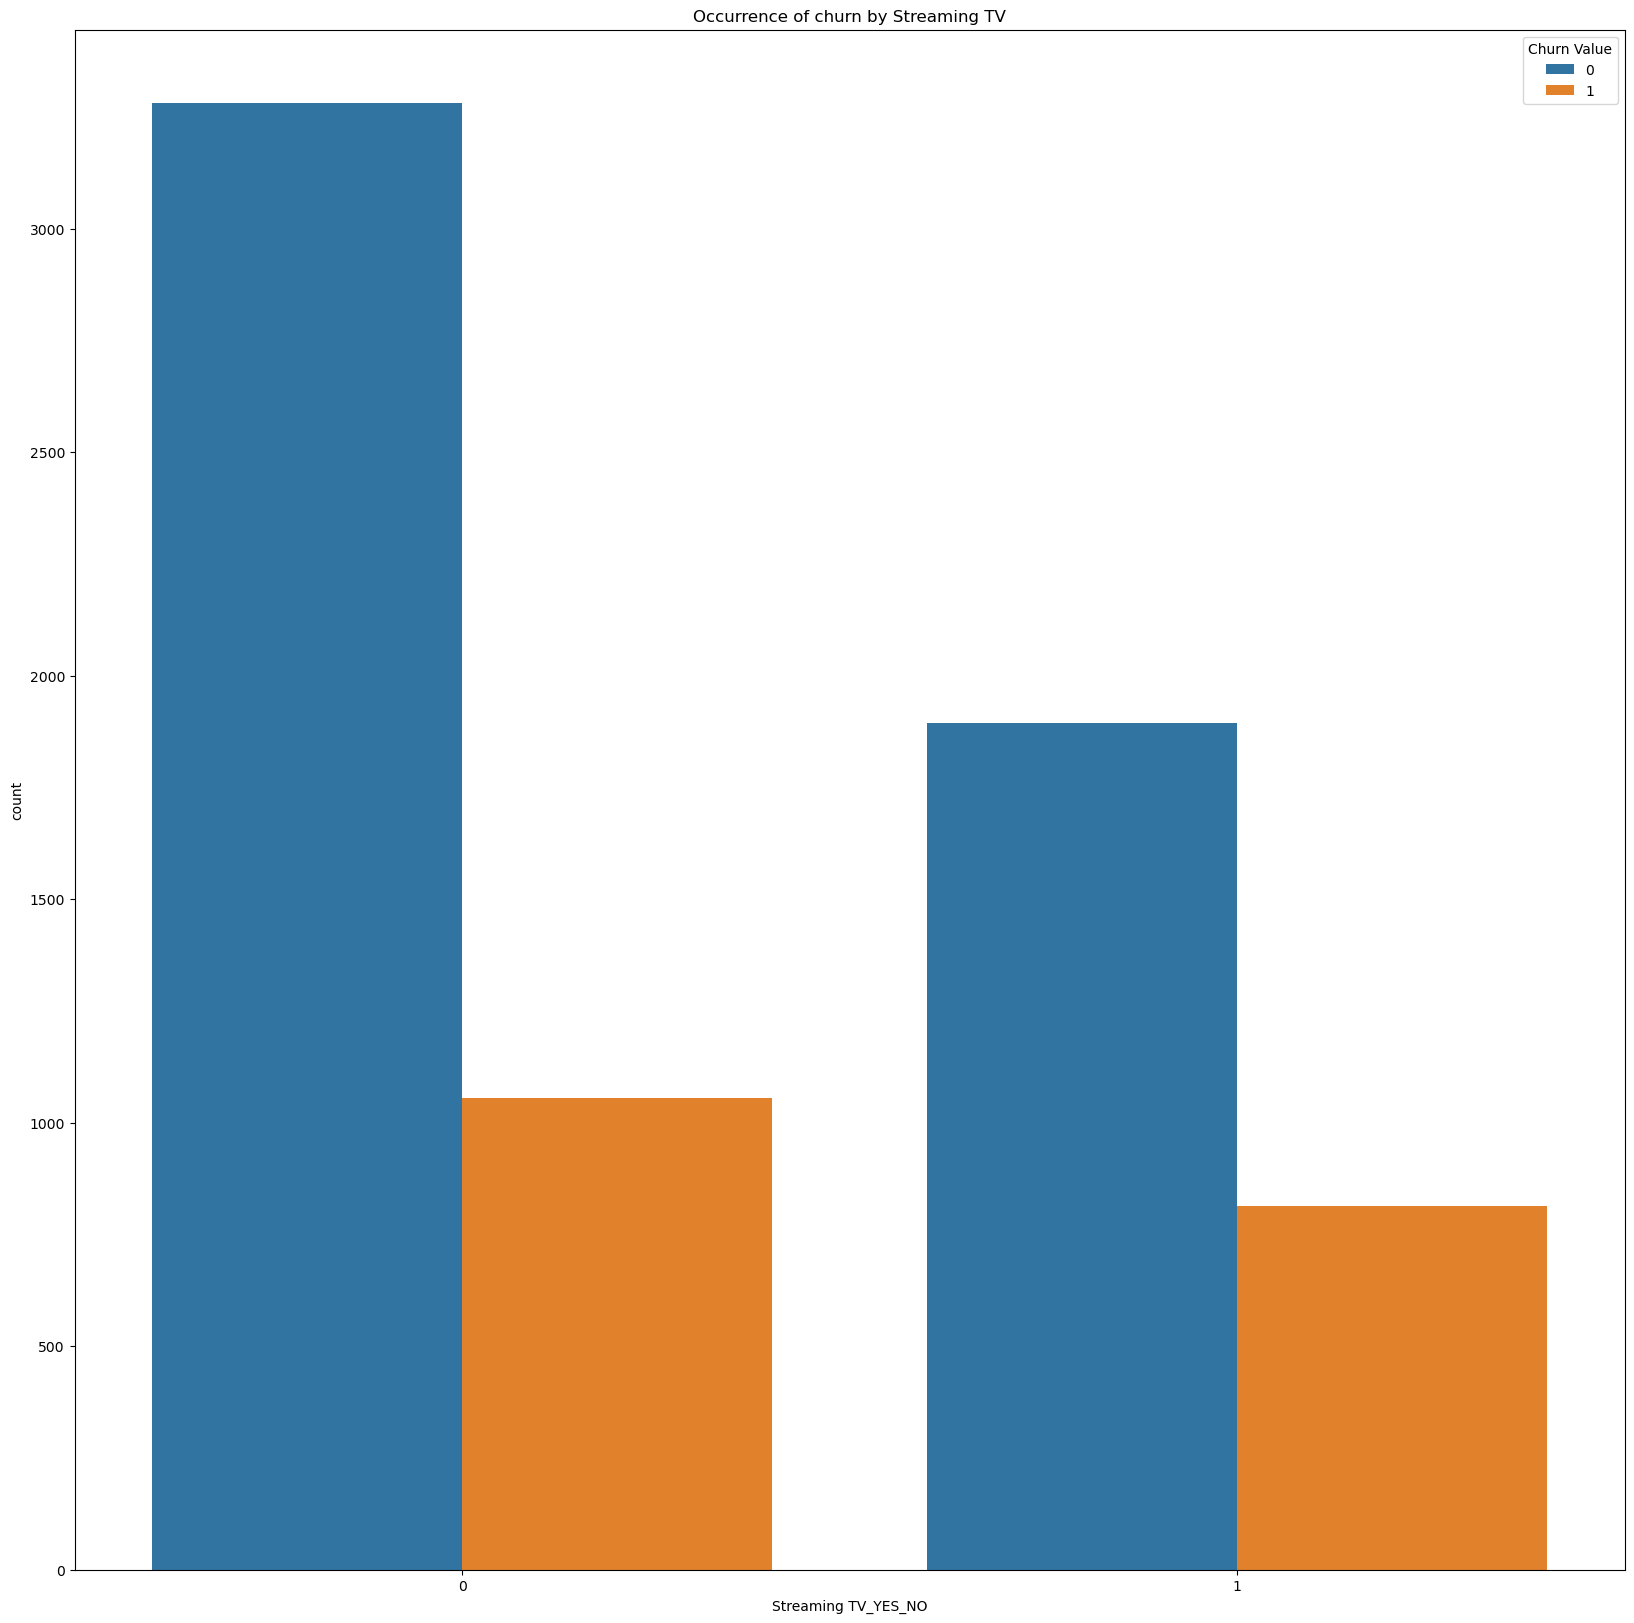

In [411]:
sns.countplot(x="Streaming TV_Yes", hue='Churn Value', data=customer_churn_data)
plt.title('Occurrence of churn by Streaming TV')
plt.xlabel("Streaming TV_YES_NO")
plt.ylabel("count")
plt.show()


# drop columns

In [154]:
X.drop(columns=["Referred a Friend_Yes","Phone Service_Yes","Internet Service_Yes","Population","Latitude","Zip Code"],inplace=True)

In [155]:
#X.drop(columns=["Population","Streaming TV_Yes"],inplace=True)

# train test split

In [156]:

X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2, stratify=y,random_state=42)

In [157]:
X_train

,Number of Dependents,Longitude,city_transform,Under 30_Yes,Gender_Male,Senior Citizen_Yes,Married_Yes,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Multiple Lines_Yes,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes,Payment Method_Bank Withdrawal,Payment Method_Mailed Check,Contract_transform
5372,-0.546024,-121.383658,1,0,1,0,0,-0.861994,0.025773,1.253986,-0.323360,-0.480015,-0.043156,-0.263975,-0.331556,0.817051,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0
111,-0.546024,-117.209774,1,1,1,0,0,-0.861994,-1.488614,1.079834,0.657745,0.712785,-1.150162,-0.263975,-0.331556,-0.698899,1,1,0,0,0,0,0,0,1,0,1,1,1,1,0,0
4457,-0.546024,-118.430656,1,0,0,0,0,-0.861994,0.386808,0.466177,-0.713914,1.317957,0.915120,-0.263975,-0.331556,0.728553,1,0,0,1,0,1,1,0,1,1,1,1,1,1,0,1
1281,-0.546024,-120.514191,1,0,1,1,0,-0.861994,-1.252963,-1.030064,-0.041419,0.229883,-0.919750,-0.263975,-0.331556,-1.106031,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0
605,-0.546024,-118.310030,1,0,0,0,0,-0.861994,-0.705192,1.461347,0.693750,1.190907,-0.108311,-0.263975,-0.331556,0.273113,1,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,-0.546024,-117.134917,1,0,1,0,1,0.429714,1.240734,0.591978,-0.600084,0.870332,1.365552,-0.263975,-0.331556,1.311731,0,0,0,1,1,1,0,0,0,1,1,1,1,0,0,1
6381,-0.546024,-119.749323,0,0,1,0,0,-0.861994,-1.362352,1.293921,0.184891,0.605679,-1.073611,-0.263975,3.016358,-0.479927,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0
3807,-0.546024,-117.122565,1,0,1,0,0,-0.861994,0.637274,1.269807,0.331162,1.527133,1.147435,-0.263975,-0.331556,1.264796,1,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0
6634,1.720463,-120.616890,0,0,0,0,1,1.432797,0.995344,-0.092030,0.544029,-0.141881,0.753866,-0.263975,-0.331556,0.766342,0,1,0,0,1,0,1,1,0,0,0,1,1,0,0,1


# oversampling

In [158]:
from imblearn.over_sampling import SMOTE
#3,4,42,32,7,19,12

In [159]:
oversampler = SMOTE(random_state=12)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [160]:
y_train.value_counts()

0    3973
1    3973
Name: Churn Value, dtype: int64

# train and buid model

In [161]:
xgbModel =xgb.XGBClassifier()

In [162]:
xgbModel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [163]:
y_pred=xgbModel.predict(X_test)


##  f1 score

In [164]:
f1 = f1_score(y_test, y_pred)
f1

0.721399730820996

## classification report

In [165]:

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       993
           1       0.71      0.74      0.72       364

    accuracy                           0.85      1357
   macro avg       0.80      0.81      0.81      1357
weighted avg       0.85      0.85      0.85      1357



## confusion matrics

In [166]:


confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

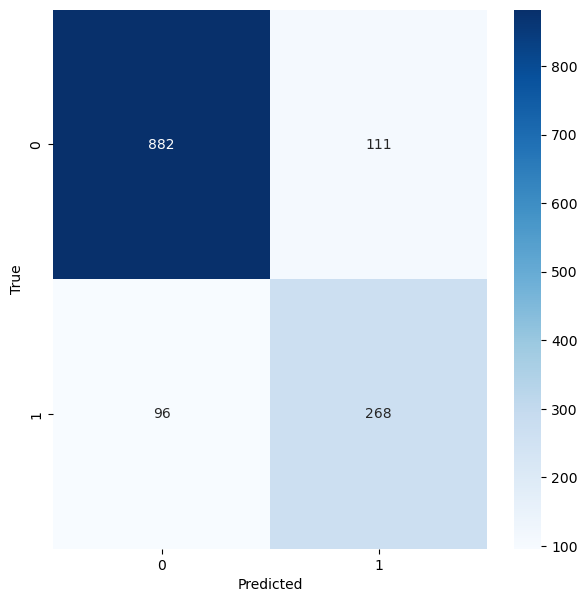

In [167]:
plt.figure(figsize=(7,7))
sns.heatmap(confusion_matrix, annot=True,  fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


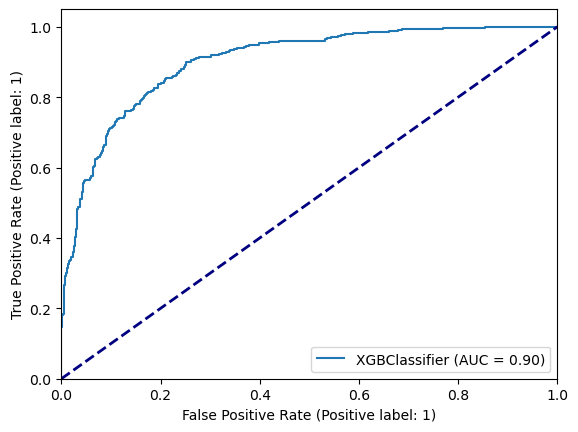

In [168]:
from sklearn.metrics import plot_roc_curve
plt.rcParams['figure.figsize'] = [6.4, 4.8] 
plot_roc_curve(xgbModel, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

# without doing oversampling

In [169]:

X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2, stratify=y,random_state=42)
xgbModel1 =xgb.XGBClassifier()
xgbModel1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [170]:
y_pred=xgbModel1.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       993
           1       0.74      0.70      0.72       364

    accuracy                           0.85      1357
   macro avg       0.82      0.81      0.81      1357
weighted avg       0.85      0.85      0.85      1357



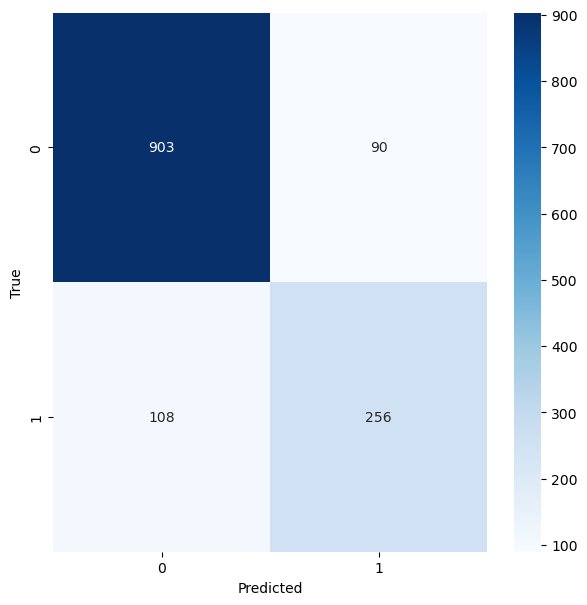

In [171]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(confusion_matrix, annot=True,  fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

# Demonstrate model  can predict unseen data 

In [172]:
new_data = {
    'Number of Dependents': 0,
    'Longitude': -122.0,
    'city_transform': 0,
    'Under 30_Yes': 1,
    'Gender_Male': 0,
    'Senior Citizen_Yes': 0,
    'Married_Yes': 1,
    'Number of Referrals': 2,
    'Tenure in Months': 14,
    'Avg Monthly Long Distance Charges': -0.75,
    'Avg Monthly GB Download': 0.5,
    'Monthly Charge': 60.0,
    'Total Charges': 700.0,
    'Total Refunds': -10.0,
    'Total Extra Data Charges': -5.0,
    'Total Long Distance Charges': 30.0,
    'Multiple Lines_Yes': 1,
    'Internet Type_Cable': 0,
    'Internet Type_DSL': 1,
    'Internet Type_Fiber Optic': 0,
    'Online Security_Yes': 1,
    'Online Backup_Yes': 1,
    'Device Protection Plan_Yes': 0,
    'Premium Tech Support_Yes': 0,
    'Streaming TV_Yes': 1,
    'Streaming Movies_Yes': 0,
    'Streaming Music_Yes': 1,
    'Unlimited Data_Yes': 1,
    'Paperless Billing_Yes': 1,
    'Payment Method_Bank Withdrawal': 0,
    'Payment Method_Mailed Check': 0,
    'Contract_transform': 0
}
new_row_df = pd.DataFrame([new_data])

In [173]:
y_pred=xgbModel.predict(new_row_df)
print(f"outcome of churn prediction:{y_pred} ")

outcome of churn prediction:[0] 


# feature importance
##  XGBoost provides insight into the importance of each feature (variable) used in the model for making predictions. It helps you understand which features have the most influence on the model's predictions.

### from the result, researcher can further prove Referred a Friend_Yes	, Internet Service_Yes, and Phone Service_Yes not  relatively less influence on the model's predictions. Changes in these features may have a smaller effect on the model's output.

In [160]:
feature_importance=pd.DataFrame(xgbModel.feature_importances_)

In [161]:
feature_importance.index= X_train.columns

In [162]:
feature_importance.sort_values(by=0)

,0
Multiple Lines_Yes,0.004644
Avg Monthly Long Distance Charges,0.005153
city_transform,0.005429
Payment Method_Bank Withdrawal,0.006152
Longitude,0.006716
Paperless Billing_Yes,0.006808
Total Charges,0.006905
Zip Code,0.007126
Total Long Distance Charges,0.007351
Latitude,0.007641


In [163]:
feature_importance.sort_values(ascending=False,by=0)[:20].index

Index(['Contract_transform', 'Number of Dependents', 'Internet Type_DSL',
       'Number of Referrals', 'Premium Tech Support_Yes', 'Under 30_Yes',
       'Online Security_Yes', 'Internet Type_Cable', 'Married_Yes',
       'Online Backup_Yes', 'Internet Type_Fiber Optic', 'Senior Citizen_Yes',
       'Avg Monthly GB Download', 'Streaming Movies_Yes',
       'Streaming Music_Yes', 'Total Extra Data Charges',
       'Payment Method_Mailed Check', 'Tenure in Months', 'Total Refunds',
       'Gender_Male'],
      dtype='object')

In [164]:
feature_importance.sort_values(ascending=False,by=0)[:5].values.ravel()

array([0.38554096, 0.07696267, 0.05545171, 0.05046093, 0.03923989],
      dtype=float32)

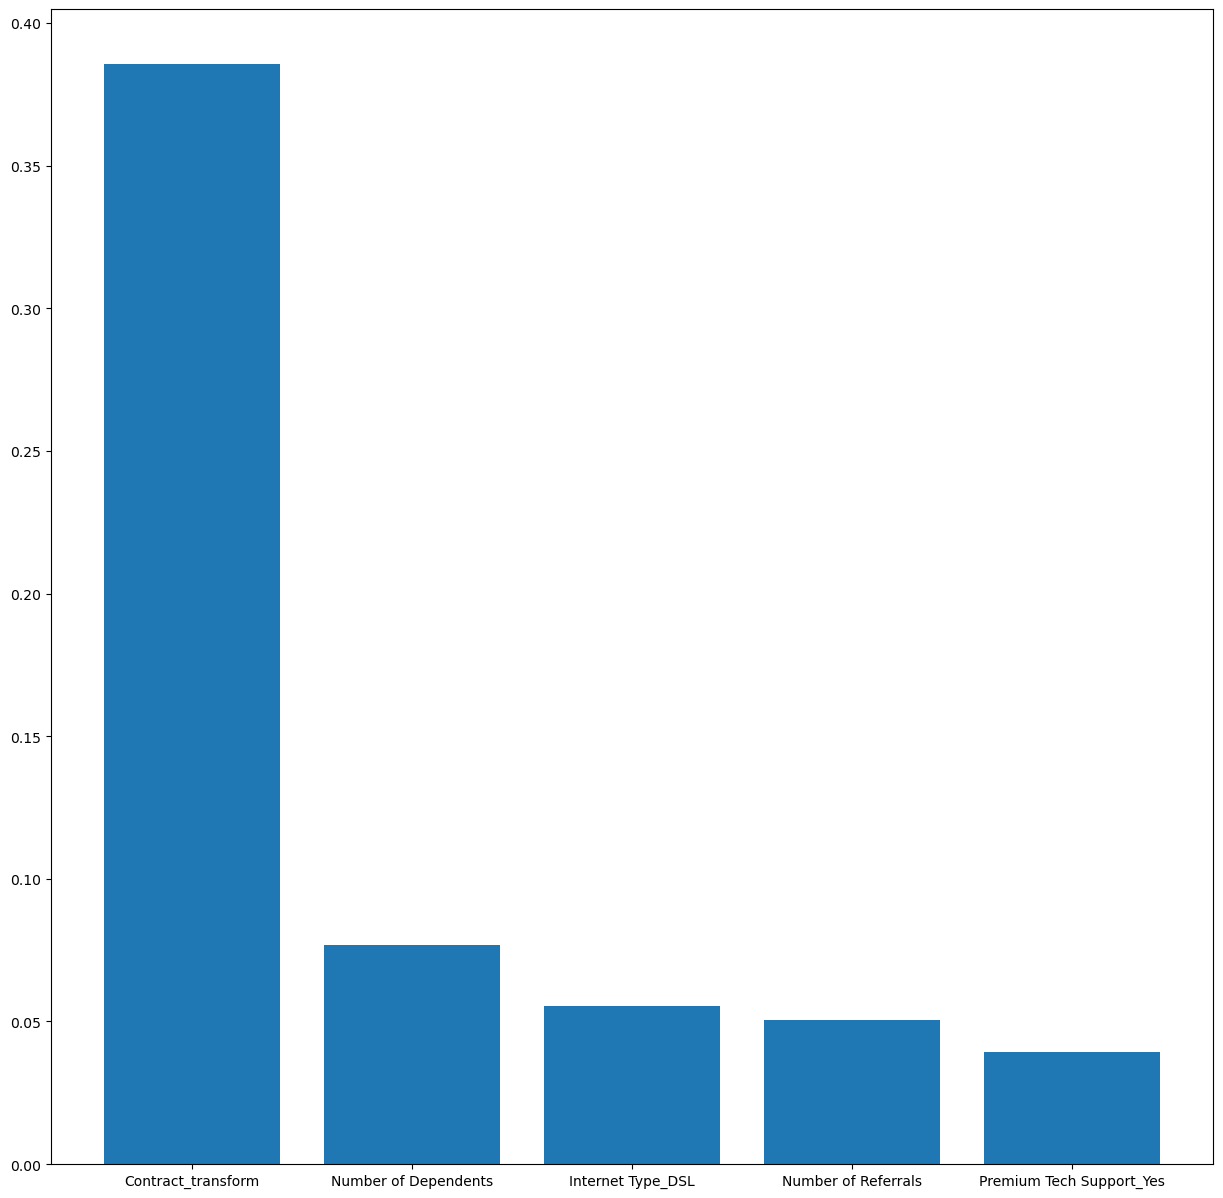

In [165]:
plt.figure(figsize=(15,15))
plt.bar([x for x in feature_importance.sort_values(ascending=False,by=0)[:5].index] ,feature_importance.sort_values(ascending=False,by=0)[:5].values.ravel())
plt.show()

## hyperparameter tuning

In [177]:
xgbModel= xgb.XGBClassifier()

In [178]:
param_grid = {
    'learning_rate': list(np.arange(0, 0.5, step=0.05)),
    'gamma': list(np.arange(1, 10, step=1)),
    'reg_lambda':list(np.arange(1, 10, step=1)),
    'max_depth':list(np.arange(1, 10, step=1))
    
    
}

grid = RandomizedSearchCV(estimator=xgbModel, param_distributions=param_grid, cv=2, scoring="f1",n_iter=500)

# Fit the Grid Search Cross-Validation object to the training data
grid.fit(X_train, y_train)

best_params = grid.best_params_
print(best_params)

{'reg_lambda': 8, 'max_depth': 3, 'learning_rate': 0.4, 'gamma': 2}


In [179]:
xgb1 = xgb.XGBClassifier(**grid.best_params_)
xgb1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [180]:
y_pred=xgb1.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1

0.7124463519313304

In [181]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       993
           1       0.74      0.68      0.71       364

    accuracy                           0.85      1357
   macro avg       0.82      0.80      0.81      1357
weighted avg       0.85      0.85      0.85      1357



In [175]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

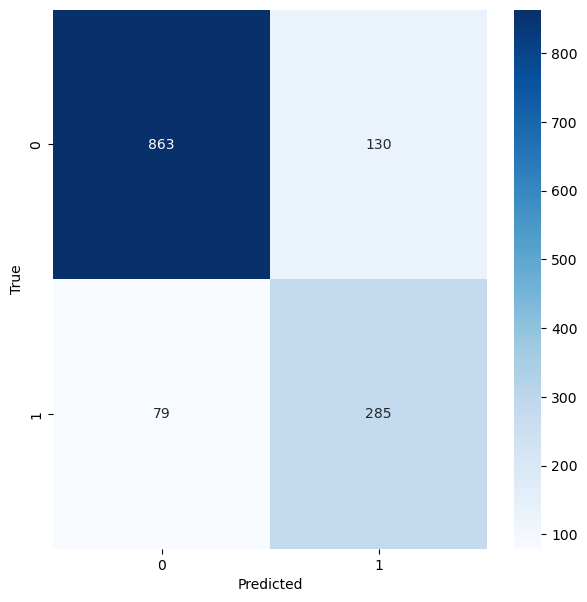

In [176]:
plt.figure(figsize=(7,7))
sns.heatmap(confusion_matrix, annot=True,  fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


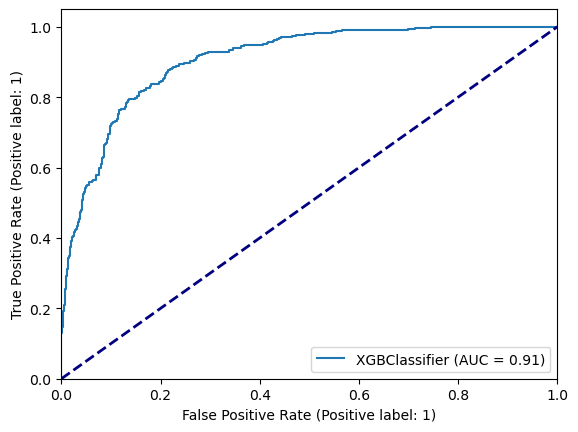

In [177]:
from sklearn.metrics import plot_roc_curve
plt.rcParams['figure.figsize'] = [6.4, 4.8] 
plot_roc_curve(xgb1, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

# save model

In [ ]:
#joblib.dump(xgb1,"model")